# Comprehensive Pulse Function Tests

This notebook tests all pulse functions with the NEW pulse definition:
- `pulse_peak_time` = `t_peak` (time where cos² is maximal)
- `pulse_FWHM` = Full Width at Half Maximum of the envelope
- Pulse exists only in `[t_peak - FWHM/2, t_peak + FWHM/2]` for cosine² envelope
- Pulse is zero outside this range
- Envelope: `cos²(π(t - t_peak)/FWHM)`

Test scenarios:
- Single pulse
- Multiple overlapping pulses
- Multiple non-overlapping pulses
- Pulses outside time range
- Different pulse parameters

In [1]:
# =============================
# IMPORT NECESSARY MODULES
# =============================
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass

# Import from our project
from src.visualization.mpl_tex_settings import *
from src.core.pulse_sequences import PulseSequence, Pulse
from src.core.pulse_functions import (
    pulse_envelope, E_pulse, Epsilon_pulse, El_field_3_pulses,
    pulse_envelope_gaussian, E_pulse_gaussian, Epsilon_pulse_gaussian
)
from src.visualization.plotting import (
    plot_pulse_envelope,
    plot_E_pulse,
    plot_Epsilon_pulse,
    plot_all_pulse_components
)

# Set matplotlib parameters for better plots
plt.rcParams['figure.dpi'] = 100
plt.rcParams['font.size'] = 10

## Test 0: New Pulse Definition Demonstration

Demonstrate the key difference between old and new pulse definitions.

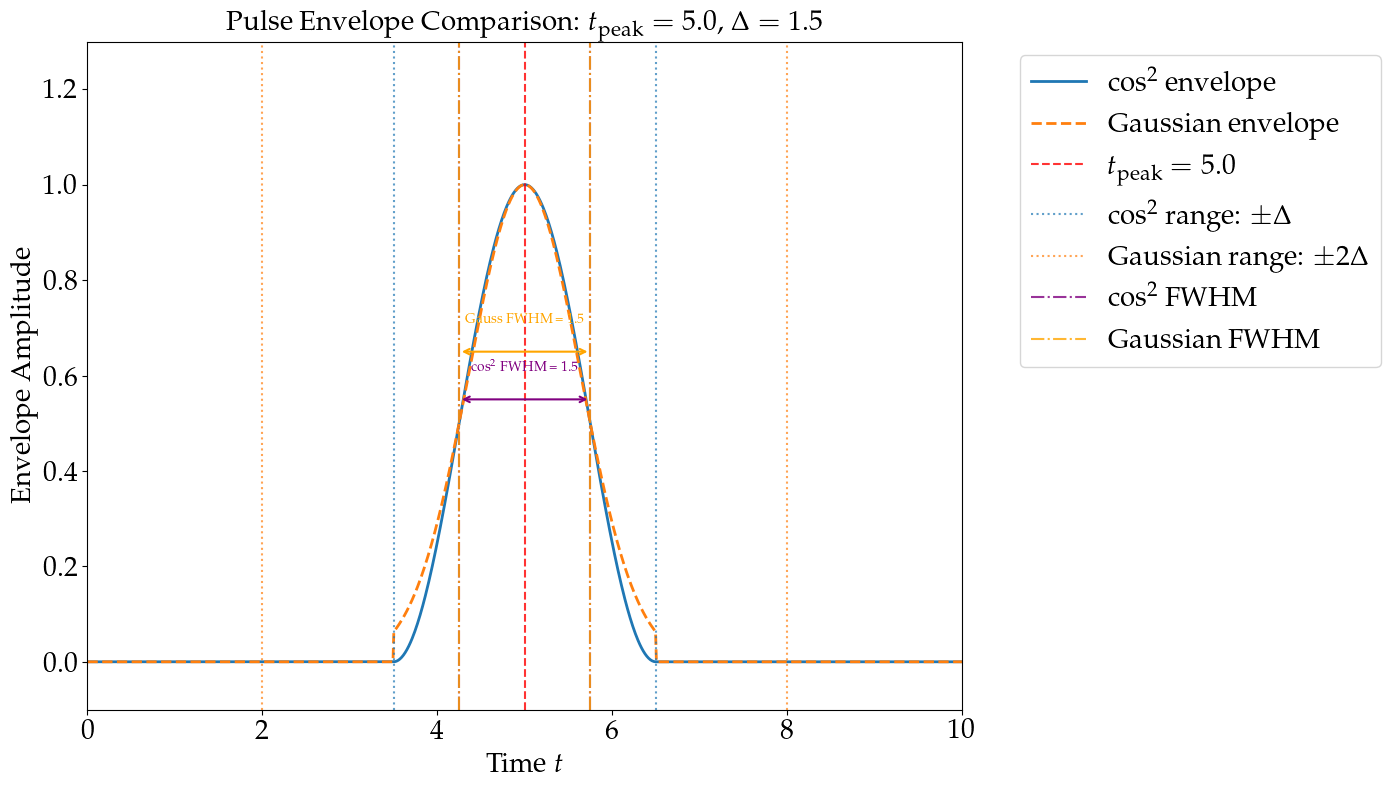

PULSE ENVELOPE COMPARISON SUMMARY:
Peak time: 5.0
Half-width parameter: 1.5

COSINE² ENVELOPE:
  Range: [3.5, 6.5] (width: 3.0)
  FWHM: 1.500 = Δ
  Peak amplitude: 1.0000

GAUSSIAN ENVELOPE:
  Range: [2.0, 8.0] (width: 6.0)
  FWHM: 1.502 ≈ 1.00 × Δ
  Peak amplitude: 1.0000

KEY DIFFERENCES:
• Gaussian envelope has 2× wider support than cosine²
• Gaussian FWHM is 1.00× larger than cosine²
• Both envelopes peak at t_peak = 5.0


In [ ]:
# =============================
# COMBINED PULSE DEFINITION DEMONSTRATION
# =============================
times_demo = np.linspace(0, 10, 1000)

# Create pulses with identical parameters
t_peak = 5.0  # Peak time
FWHM = 1.5   # Full Width at Half Maximum

### Cosine² and Gaussian pulse / sequence
demo_pulse = Pulse(
    pulse_peak_time=t_peak,
    pulse_FWHM=FWHM,
    pulse_amplitude=1.0,
    pulse_phase=0.0,
    pulse_freq=3.0
)
demo_seq = PulseSequence([demo_pulse])

# Calculate envelopes
envelope_vals_cos2  = [pulse_envelope(t, demo_seq) for t in times_demo]
envelope_vals_gauss = [pulse_envelope_gaussian(t, demo_seq) for t in times_demo]

### Calculate FWHM values
# Cosine²: FWHM = pulse_FWHM parameter (analytical)
fwhm_cos2     = FWHM
half_max_cos2 = 0.5

# Gaussian: FWHM determined numerically
gauss_peak   = pulse_envelope_gaussian(t_peak, demo_seq)
half_max_gauss = gauss_peak / 2

def find_gauss_fwhm_points(t_peak: float, FWHM: float, half_max: float, demo_seq: PulseSequence) -> tuple:
    """Find FWHM points for Gaussian envelope"""
    t_search        = np.linspace(t_peak - 2*FWHM, t_peak + 2*FWHM, 10000)
    envelope_search = [pulse_envelope_gaussian(t, demo_seq) for t in t_search]
    
    # Find closest points to half maximum
    half_max_indices = []
    for i, env_val in enumerate(envelope_search):
        if abs(env_val - half_max) < 0.001:
            half_max_indices.append(i)
    
    if len(half_max_indices) >= 2:
        return t_search[half_max_indices[0]], t_search[half_max_indices[-1]]
    else:
        # Theoretical approximation
        fwhm_approx = 1.67 * FWHM
        print("Warning: Could not find FWHM points numerically, using approximation.")
        return t_peak - fwhm_approx/2, t_peak + fwhm_approx/2

t_fwhm_left_gauss, t_fwhm_right_gauss = find_gauss_fwhm_points(t_peak, FWHM, half_max_gauss, demo_seq)
fwhm_gauss = t_fwhm_right_gauss - t_fwhm_left_gauss

# FWHM points for cosine²
t_fwhm_left_cos2  = t_peak - fwhm_cos2/2
t_fwhm_right_cos2 = t_peak + fwhm_cos2/2

### Plot combined demonstration
plt.figure(figsize=(14, 8))

# Plot both envelopes
plt.plot(times_demo, envelope_vals_cos2, label=r'$\cos^2$ envelope', linewidth=2, color='C0', linestyle='solid')
plt.plot(times_demo, envelope_vals_gauss, label='Gaussian envelope', linewidth=2, color='C1', linestyle='dashed')

# Mark peak time
plt.axvline(t_peak, color='red', linestyle='--', alpha=0.8, label=rf'$t_{{\text{{peak}}}} = {t_peak}$')

# Mark pulse boundaries
plt.axvline(t_peak - FWHM/2, color='C0', linestyle=':', alpha=0.7, label=rf'$\cos^2$ range: $\pm$ FWHM/2')
plt.axvline(t_peak + FWHM/2, color='C0', linestyle=':', alpha=0.7)
plt.axvline(t_peak - FWHM, color='C1', linestyle=':', alpha=0.7, label=r'Gaussian range: $\pm$ FWHM')
plt.axvline(t_peak + FWHM, color='C1', linestyle=':', alpha=0.7)

# Mark FWHM points for cosine²
plt.axvline(t_fwhm_left_cos2, color='purple', linestyle='-.', alpha=0.8, label=rf'$\cos^2$ FWHM')
plt.axvline(t_fwhm_right_cos2, color='purple', linestyle='-.', alpha=0.8)

# Mark FWHM points for Gaussian
plt.axvline(t_fwhm_left_gauss, color='orange', linestyle='-.', alpha=0.8, label='Gaussian FWHM')
plt.axvline(t_fwhm_right_gauss, color='orange', linestyle='-.', alpha=0.8)

# Add FWHM annotations
plt.annotate('', xy=(t_fwhm_left_cos2, half_max_cos2 + 0.05), xytext=(t_fwhm_right_cos2, half_max_cos2 + 0.05),
            arrowprops=dict(arrowstyle='<->', color='purple', lw=1.5))
plt.text((t_fwhm_left_cos2 + t_fwhm_right_cos2)/2, half_max_cos2 + 0.1, 
         rf'$\cos^2$ FWHM = {fwhm_cos2:.1f}', ha='center', va='bottom',
         color='purple', fontweight='bold', fontsize=10)

plt.annotate('', xy=(t_fwhm_left_gauss, half_max_gauss + 0.15), xytext=(t_fwhm_right_gauss, half_max_gauss + 0.15),
            arrowprops=dict(arrowstyle='<->', color='orange', lw=1.5))
plt.text((t_fwhm_left_gauss + t_fwhm_right_gauss)/2, half_max_gauss + 0.2, 
         rf'Gauss FWHM = {fwhm_gauss:.1f}', ha='center', va='bottom',
         color='orange', fontweight='bold', fontsize=10)

plt.xlabel(r'Time $t$')
plt.ylabel('Envelope Amplitude')
plt.title(rf'Pulse Envelope Comparison: $t_{{\text{{peak}}}} = {t_peak}$, FWHM = {FWHM}')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlim(0, 10)
plt.ylim(-0.1, 1.3)
plt.tight_layout()
plt.show()

### Summary output
print(f"PULSE ENVELOPE COMPARISON SUMMARY:")
print(f"Peak time: {t_peak}")
print(f"FWHM parameter: {FWHM}")
print(f"")
print(f"COSINE² ENVELOPE:")
print(f"  Range: [{t_peak - FWHM/2:.1f}, {t_peak + FWHM/2:.1f}] (width: {FWHM:.1f})")
print(f"  FWHM: {fwhm_cos2:.3f} = pulse_FWHM parameter")
print(f"  Peak amplitude: {pulse_envelope(t_peak, demo_seq):.4f}")
print(f"")
print(f"GAUSSIAN ENVELOPE:")
print(f"  Range: [{t_peak - FWHM:.1f}, {t_peak + FWHM:.1f}] (width: {2*FWHM:.1f})")
print(f"  FWHM: {fwhm_gauss:.3f} ≈ {fwhm_gauss/FWHM:.2f} × pulse_FWHM")
print(f"  Peak amplitude: {pulse_envelope_gaussian(t_peak, demo_seq):.4f}")
print(f"")
print(f"KEY DIFFERENCES:")
print(f"• Gaussian envelope has {2:.0f}× wider support than cosine²")
print(f"• Gaussian FWHM is {fwhm_gauss/fwhm_cos2:.2f}× larger than cosine²")
print(f"• Both envelopes peak at t_peak = {t_peak}")

## Test 1: Single Pulse Analysis

In [ ]:
# =============================
# SINGLE PULSE PARAMETERS
# =============================
times = np.linspace(0, 10, 1000)

# Create single pulse
single_pulse = Pulse(
    pulse_peak_time=5.0,  # t_peak - peak time where cos² is maximal
    pulse_FWHM=1.0,  # FWHM - Full Width at Half Maximum
    pulse_amplitude=1.0,
    pulse_phase=0.0,
    pulse_freq=5.0
)

single_pulse_seq = PulseSequence([single_pulse])

print(f"Single pulse parameters:")
print(f"Peak time (t_peak): {single_pulse.pulse_peak_time}")
print(f"FWHM: {single_pulse.pulse_FWHM}")
print(f"Pulse range: [{single_pulse.pulse_peak_time - single_pulse.pulse_FWHM/2:.1f}, {single_pulse.pulse_peak_time + single_pulse.pulse_FWHM/2:.1f}]")
print(f"Amplitude: {single_pulse.pulse_amplitude}")
print(f"Phase: {single_pulse.pulse_phase}")
print(f"Frequency: {single_pulse.pulse_freq}")

Single pulse parameters:
Peak time (t_peak): 5.0
Half width (Delta): 1.0
Pulse range: [4.0, 6.0]
Amplitude: 1.0
Phase: 0.0
Frequency: 5.0


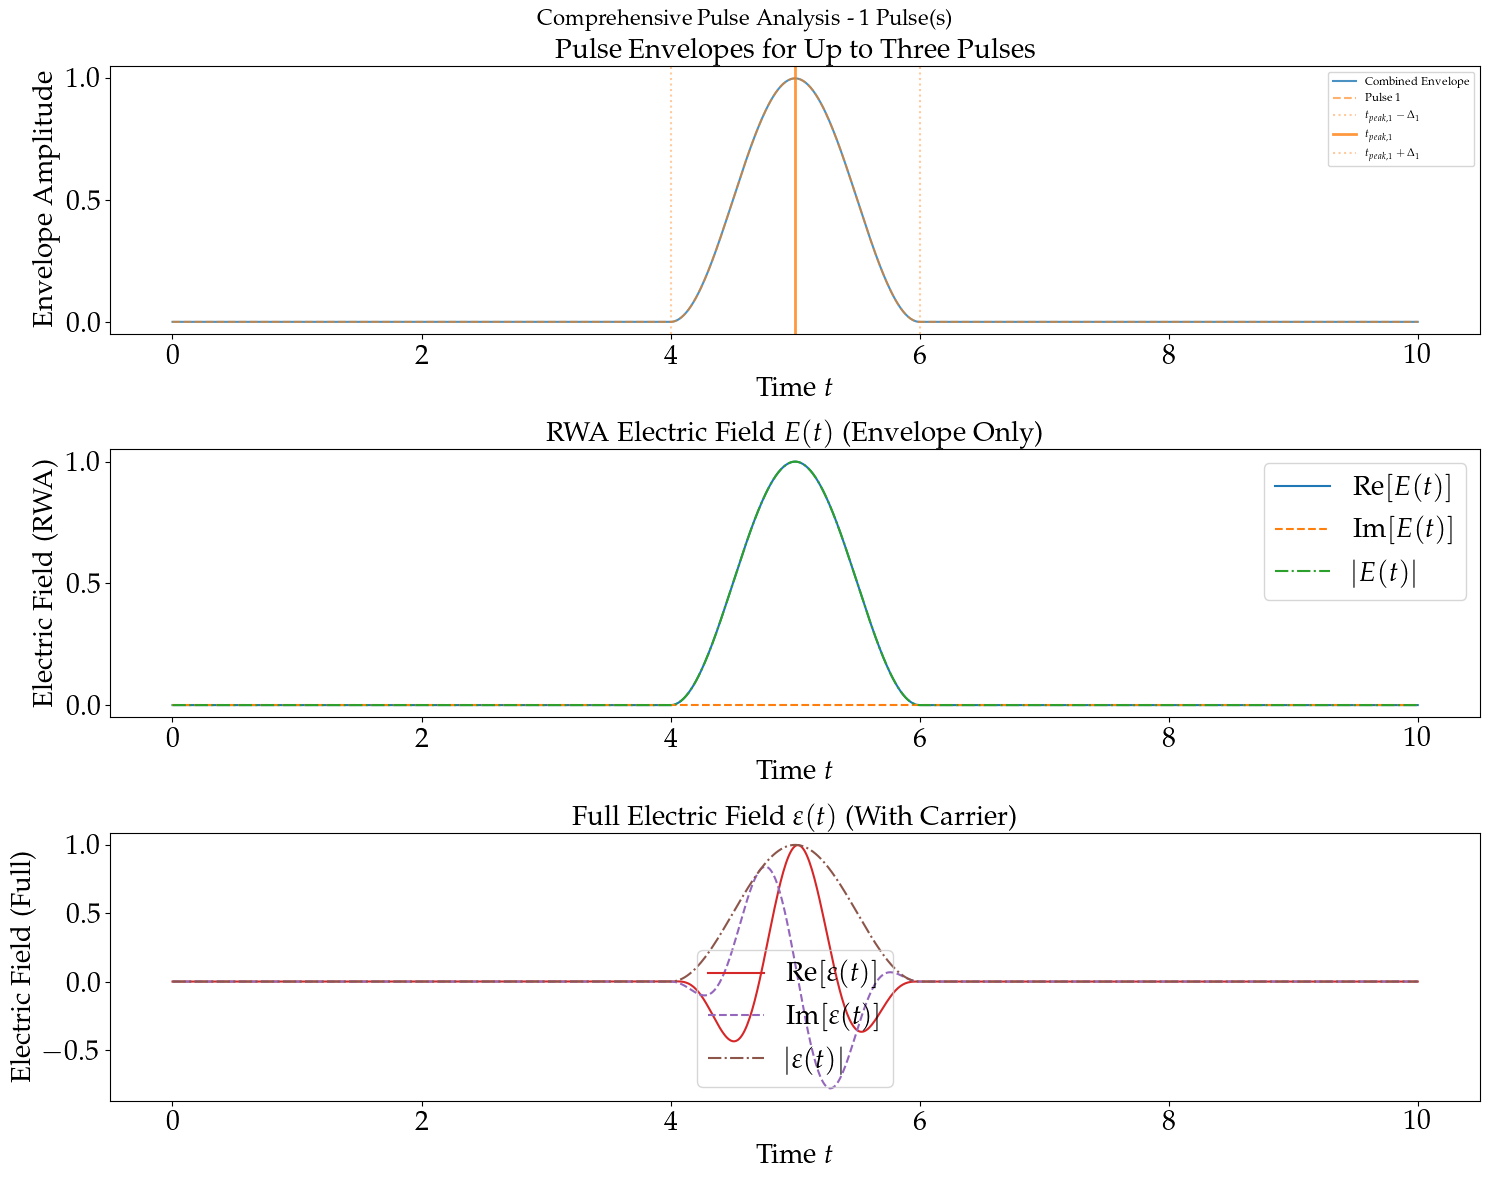

In [4]:
# Plot comprehensive analysis for single pulse
fig = plot_all_pulse_components(times, single_pulse_seq)
plt.show()

## Test 2: Two Overlapping Pulses

In [ ]:
# =============================
# OVERLAPPING PULSES PARAMETERS
# =============================
pulse1_overlap = Pulse(
    pulse_peak_time=3.0,  # t_peak for pulse 1
    pulse_FWHM=1.5,  # FWHM for pulse 1
    pulse_amplitude=1.0,
    pulse_phase=0.0,
    pulse_freq=4.0
)

pulse2_overlap = Pulse(
    pulse_peak_time=4.0,  # t_peak for pulse 2
    pulse_FWHM=1.2,  # FWHM for pulse 2
    pulse_amplitude=0.8,
    pulse_phase=np.pi/4,
    pulse_freq=6.0
)

overlapping_seq = PulseSequence([pulse1_overlap, pulse2_overlap])

# Calculate pulse ranges with new definition
pulse1_start = pulse1_overlap.pulse_peak_time - pulse1_overlap.pulse_FWHM/2
pulse1_end = pulse1_overlap.pulse_peak_time + pulse1_overlap.pulse_FWHM/2
pulse2_start = pulse2_overlap.pulse_peak_time - pulse2_overlap.pulse_FWHM/2
pulse2_end = pulse2_overlap.pulse_peak_time + pulse2_overlap.pulse_FWHM/2

print(f"Overlapping pulses:")
print(f"Pulse 1: t_peak={pulse1_overlap.pulse_peak_time}, FWHM={pulse1_overlap.pulse_FWHM}, range=[{pulse1_start:.1f}, {pulse1_end:.1f}], freq={pulse1_overlap.pulse_freq}")
print(f"Pulse 2: t_peak={pulse2_overlap.pulse_peak_time}, FWHM={pulse2_overlap.pulse_FWHM}, range=[{pulse2_start:.1f}, {pulse2_end:.1f}], freq={pulse2_overlap.pulse_freq}")
print(f"Overlap region: [{max(pulse1_start, pulse2_start):.1f}, {min(pulse1_end, pulse2_end):.1f}]")

Overlapping pulses:
Pulse 1: t_peak=3.0, Delta=1.5, range=[1.5, 4.5], freq=4.0
Pulse 2: t_peak=4.0, Delta=1.2, range=[2.8, 5.2], freq=6.0
Overlap region: [2.8, 4.5]


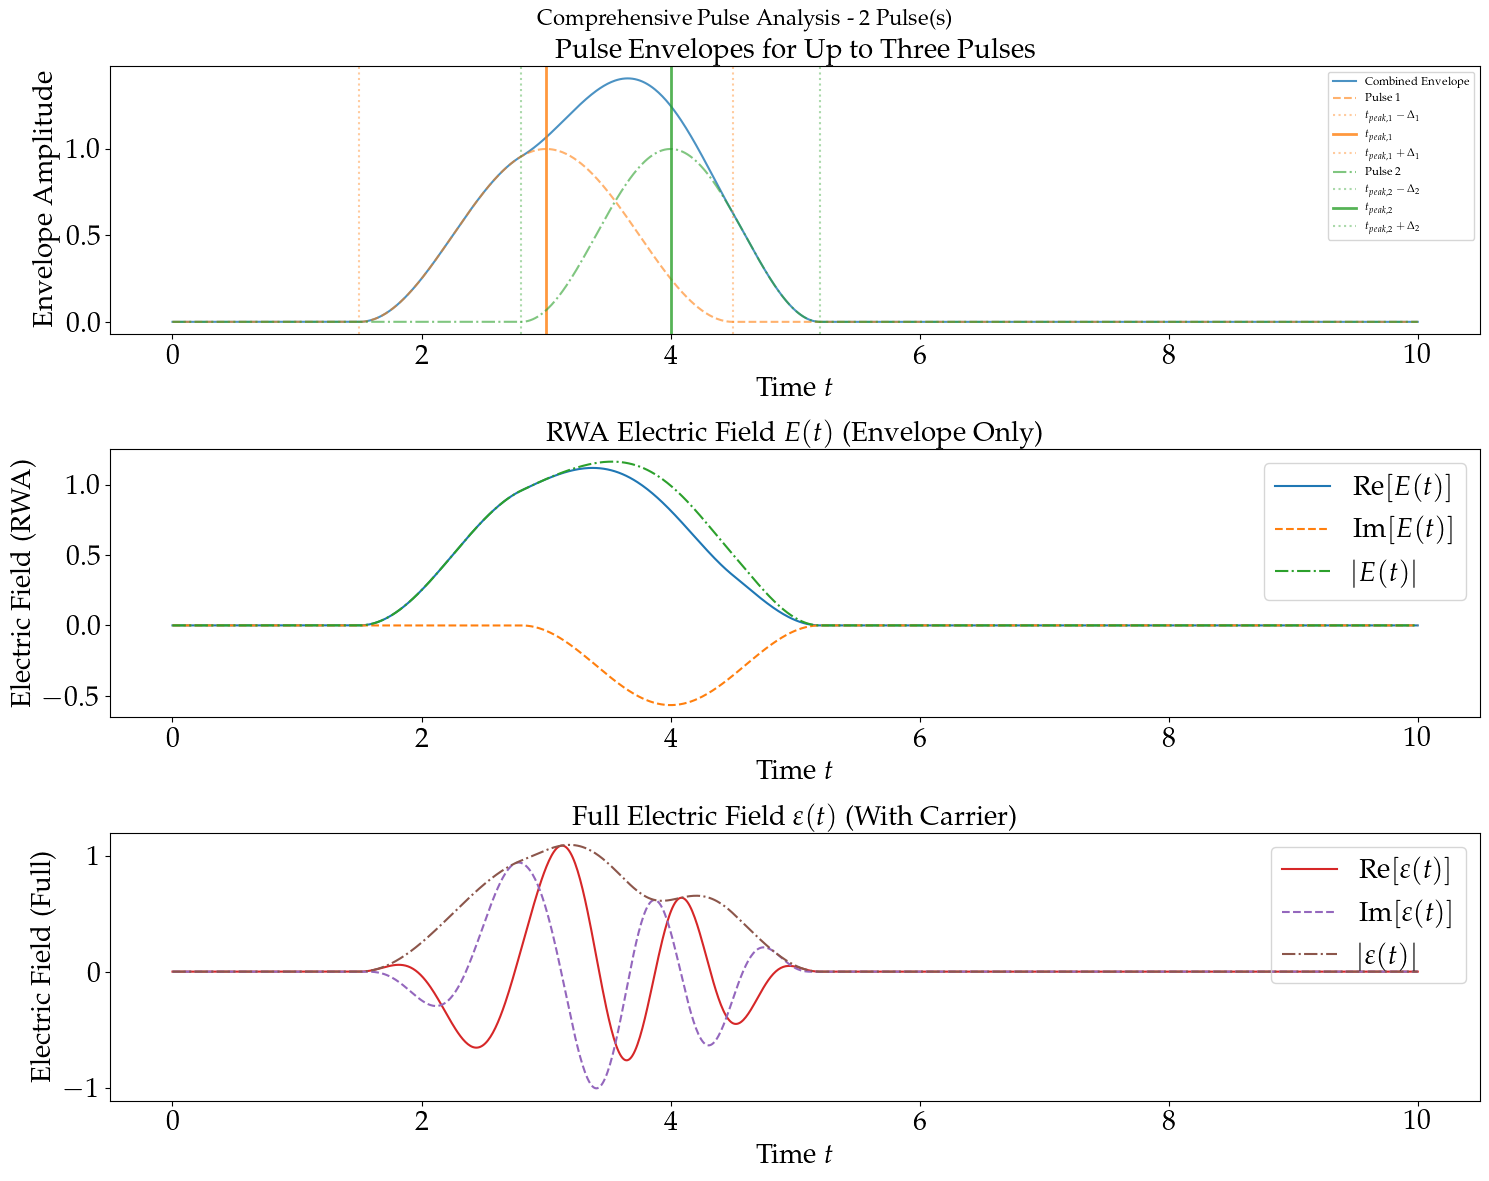

In [6]:
# Plot comprehensive analysis for overlapping pulses
fig = plot_all_pulse_components(times, overlapping_seq)
plt.show()

## Test 3: Three Non-Overlapping Pulses

In [ ]:
# =============================
# NON-OVERLAPPING PULSES PARAMETERS
# =============================
pulse1_separate = Pulse(
    pulse_peak_time=2.0,  # t_peak for pulse 1
    pulse_FWHM=0.8,  # Delta for pulse 1
    pulse_amplitude=1.2,
    pulse_phase=0.0,
    pulse_freq=3.0
)

pulse2_separate = Pulse(
    pulse_peak_time=5.0,  # t_peak for pulse 2
    pulse_FWHM=0.6,  # Delta for pulse 2
    pulse_amplitude=0.9,
    pulse_phase=np.pi/2,
    pulse_freq=5.0
)

pulse3_separate = Pulse(
    pulse_peak_time=8.0,  # t_peak for pulse 3
    pulse_FWHM=1.0,  # Delta for pulse 3
    pulse_amplitude=0.7,
    pulse_phase=np.pi,
    pulse_freq=7.0
)

separate_seq = PulseSequence([pulse1_separate, pulse2_separate, pulse3_separate])

print(f"Three separate pulses:")
for i, pulse in enumerate(separate_seq.pulses):
    pulse_start = pulse.pulse_peak_time - pulse.pulse_FWHM
    pulse_end = pulse.pulse_peak_time + pulse.pulse_FWHM
    print(f"Pulse {i+1}: t_peak={pulse.pulse_peak_time}, Delta={pulse.pulse_FWHM}, range=[{pulse_start:.1f}, {pulse_end:.1f}], amp={pulse.pulse_amplitude}, phase={pulse.pulse_phase:.2f}, freq={pulse.pulse_freq}")

Three separate pulses:
Pulse 1: t_peak=2.0, Delta=0.8, range=[1.2, 2.8], amp=1.2, phase=0.00, freq=3.0
Pulse 2: t_peak=5.0, Delta=0.6, range=[4.4, 5.6], amp=0.9, phase=1.57, freq=5.0
Pulse 3: t_peak=8.0, Delta=1.0, range=[7.0, 9.0], amp=0.7, phase=3.14, freq=7.0


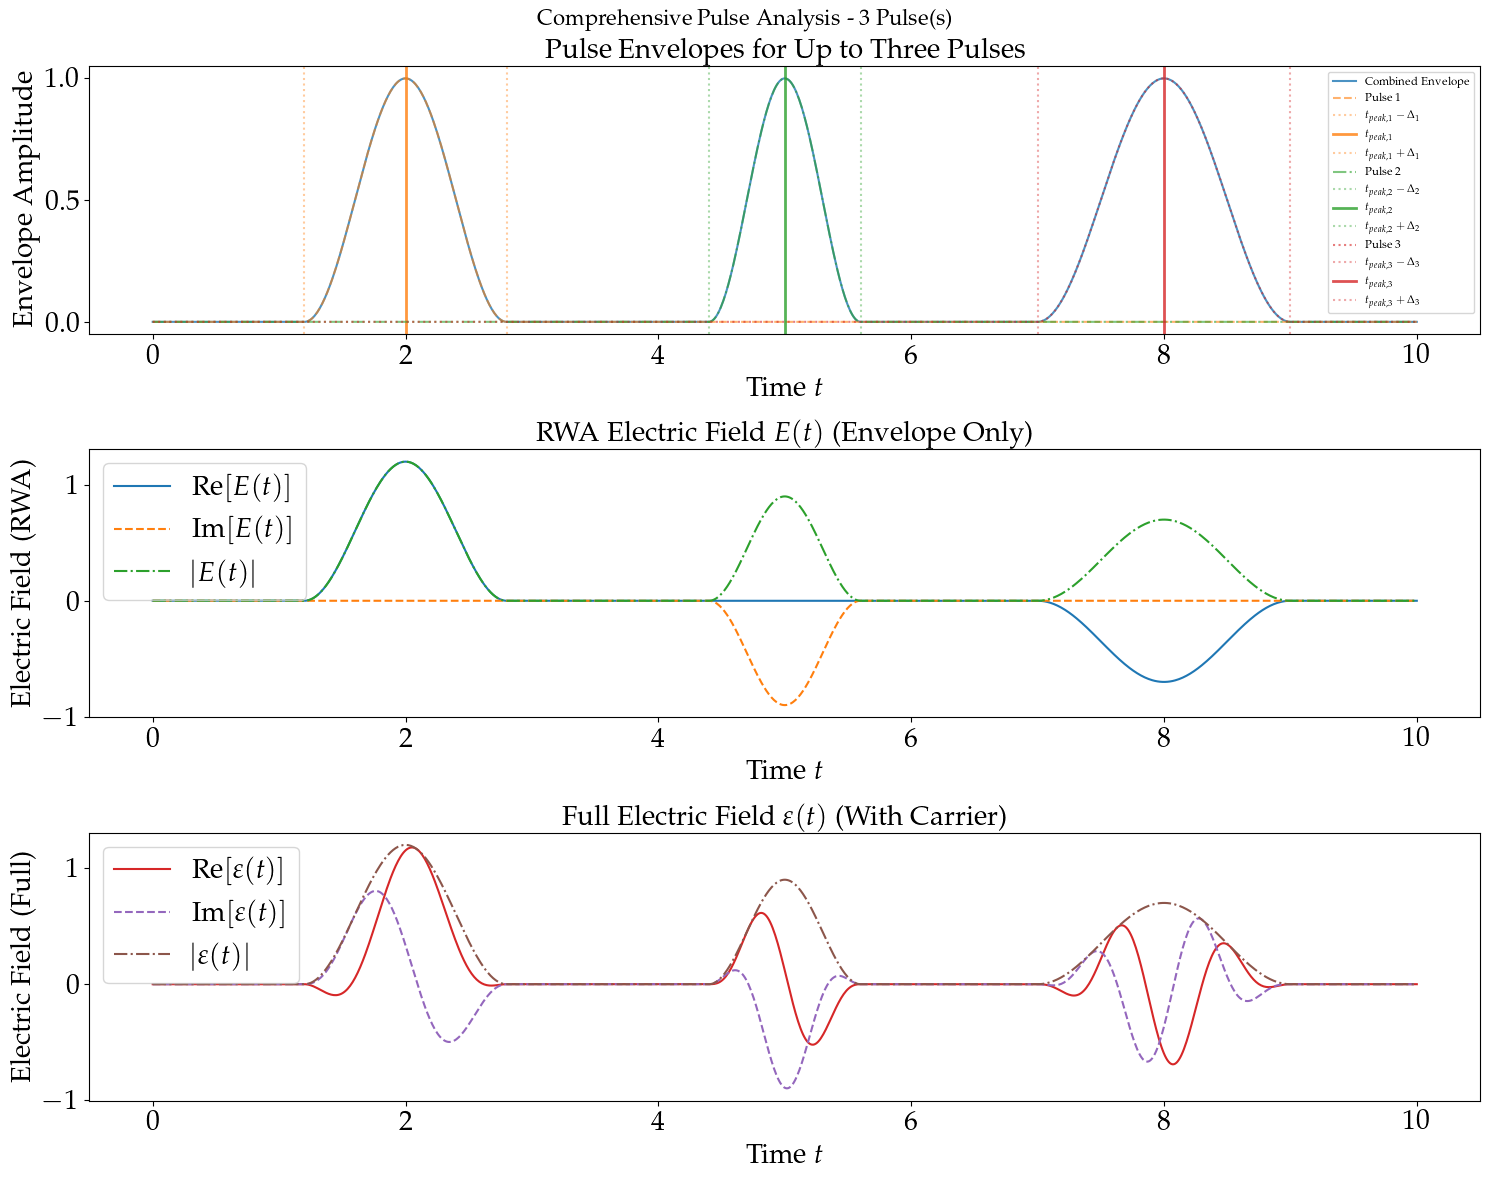

In [11]:
# Plot comprehensive analysis for separate pulses
fig = plot_all_pulse_components(times, separate_seq)
plt.show()

## Test 4: Edge Cases - Pulses Outside Time Range

In [ ]:
# =============================
# EDGE CASE: PULSES OUTSIDE RANGE
# =============================
times_narrow = np.linspace(0, 10, 1000)  # Narrow time window

pulse_before = Pulse(
    pulse_peak_time=0.5,  # t_peak before time window (range: [-0.5, 1.5])
    pulse_FWHM=1.0,
    pulse_amplitude=1.0,
    pulse_phase=0.0,
    pulse_freq=4.0
)

pulse_during = Pulse(
    pulse_peak_time=4.0,  # t_peak during time window (range: [3.2, 4.8])
    pulse_FWHM=0.8,
    pulse_amplitude=1.0,
    pulse_phase=np.pi/3,
    pulse_freq=6.0
)

pulse_after = Pulse(
    pulse_peak_time=9.5,  # t_peak after time window (range: [6.8, 9.2])
    pulse_FWHM=1.2,
    pulse_amplitude=1.0,
    pulse_phase=0.0,
    pulse_freq=5.0
)

edge_case_seq = PulseSequence([pulse_before, pulse_during, pulse_after])

print(f"Edge case pulses with narrow time window [{times_narrow[0]:.1f}, {times_narrow[-1]:.1f}]:")
for i, (pulse, label) in enumerate(zip([pulse_before, pulse_during, pulse_after], ["before", "during", "after"])):
    pulse_start = pulse.pulse_peak_time - pulse.pulse_FWHM
    pulse_end = pulse.pulse_peak_time + pulse.pulse_FWHM
    print(f"Pulse {label}: t_peak={pulse.pulse_peak_time}, range=[{pulse_start:.1f}, {pulse_end:.1f}] ({label} window)")

Edge case pulses with narrow time window [0.0, 10.0]:
Pulse before: t_peak=0.5, range=[-0.5, 1.5] (before window)
Pulse during: t_peak=4.0, range=[3.2, 4.8] (during window)
Pulse after: t_peak=9.5, range=[8.3, 10.7] (after window)


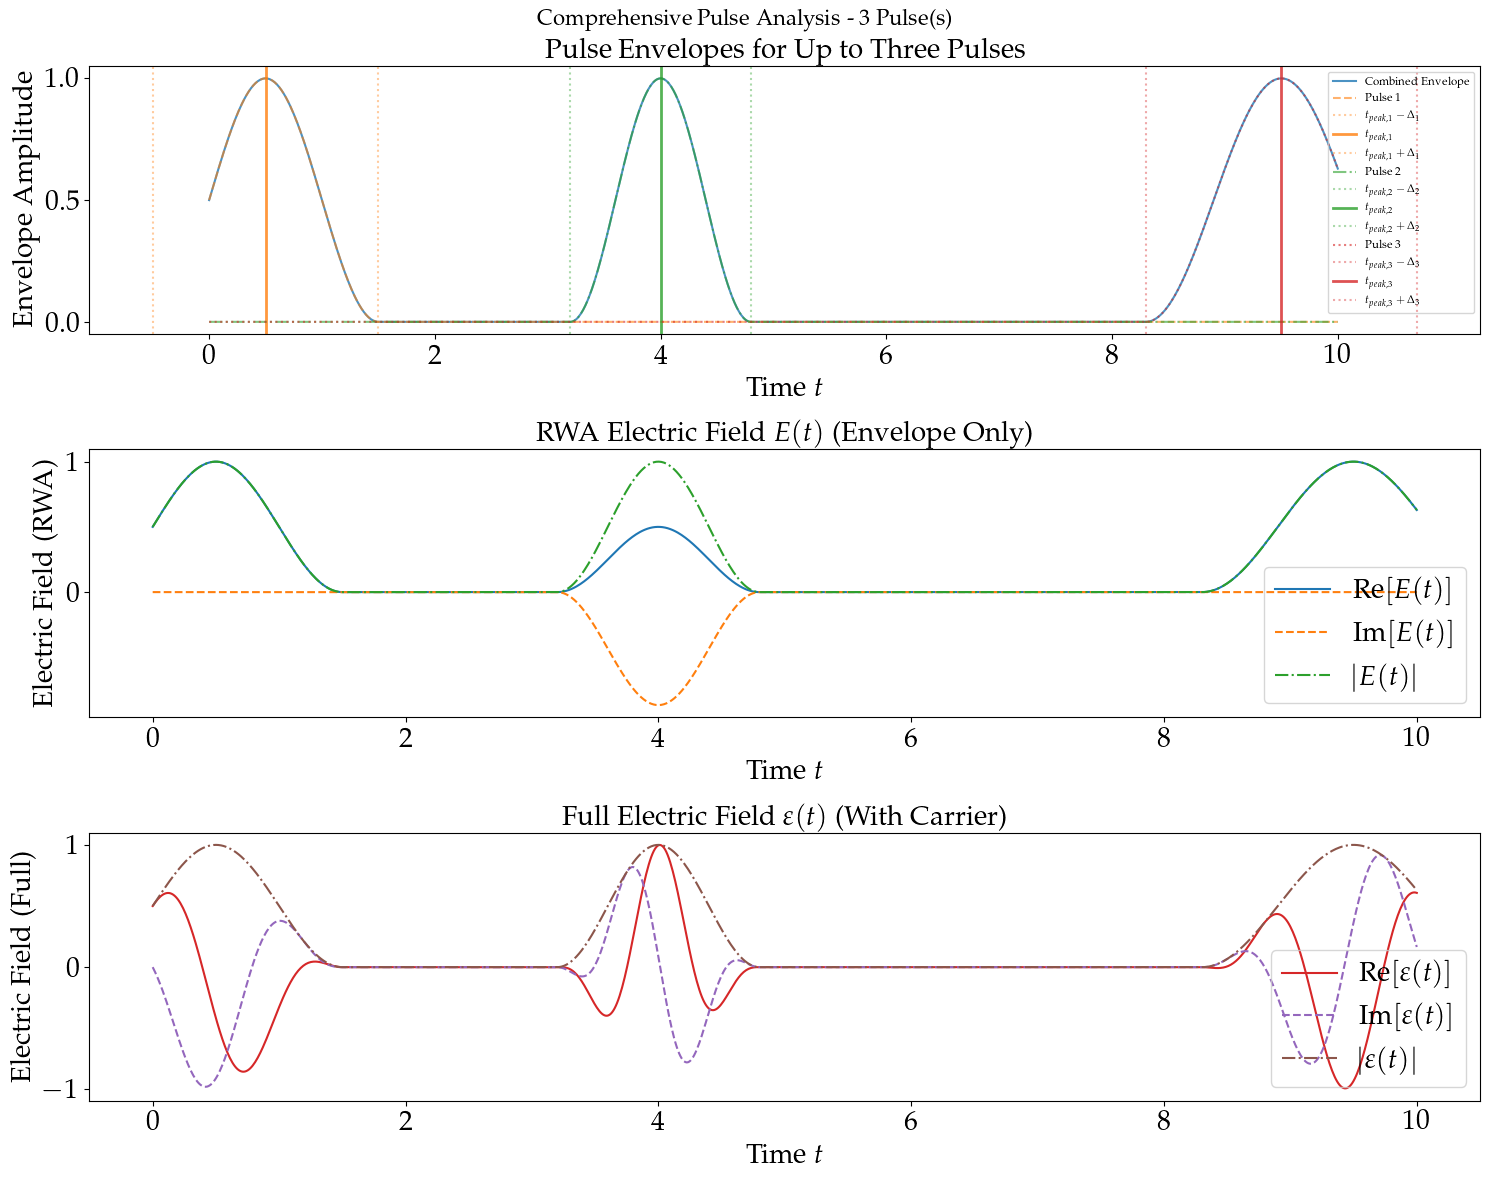

In [19]:
# Plot edge case analysis
fig = plot_all_pulse_components(times_narrow, edge_case_seq)
plt.show()

## Test 5: Function Validation - Individual Components

In [ ]:
# =============================
# FUNCTION VALIDATION
# =============================
test_times = np.linspace(0, 8, 800)

# Test pulse for validation
test_pulse = Pulse(
    pulse_peak_time=2.0,
    pulse_FWHM=1.5,
    pulse_amplitude=2.0,
    pulse_phase=np.pi/6,
    pulse_freq=4.0
)
test_seq = PulseSequence([test_pulse])

# Calculate functions at specific times
test_t = 3.0  # Middle of pulse
envelope_val = pulse_envelope(test_t, test_seq)
E_val = E_pulse(test_t, test_seq)
Epsilon_val = Epsilon_pulse(test_t, test_seq)

print(f"Function values at t = {test_t}:")
print(f"Envelope: {envelope_val:.4f}")
print(f"E_pulse: {E_val:.4f}")
print(f"Epsilon_pulse: {Epsilon_val:.4f}")

# Test El_field_3_pulses function
E_envelope = El_field_3_pulses(test_times, test_seq, f=pulse_envelope)
E_rwa = El_field_3_pulses(test_times, test_seq, f=E_pulse)
E_full = El_field_3_pulses(test_times, test_seq, f=Epsilon_pulse)

print(f"\nEl_field_3_pulses function test:")
print(f"Envelope array shape: {E_envelope.shape}")
print(f"RWA array shape: {E_rwa.shape}")
print(f"Full array shape: {E_full.shape}")

Function values at t = 3.0:
Envelope: 0.2500
E_pulse: 0.4330-0.2500j
Epsilon_pulse: 0.4995+0.0214j

El_field_3_pulses function test:
Envelope array shape: (800,)
RWA array shape: (800,)
Full array shape: (800,)


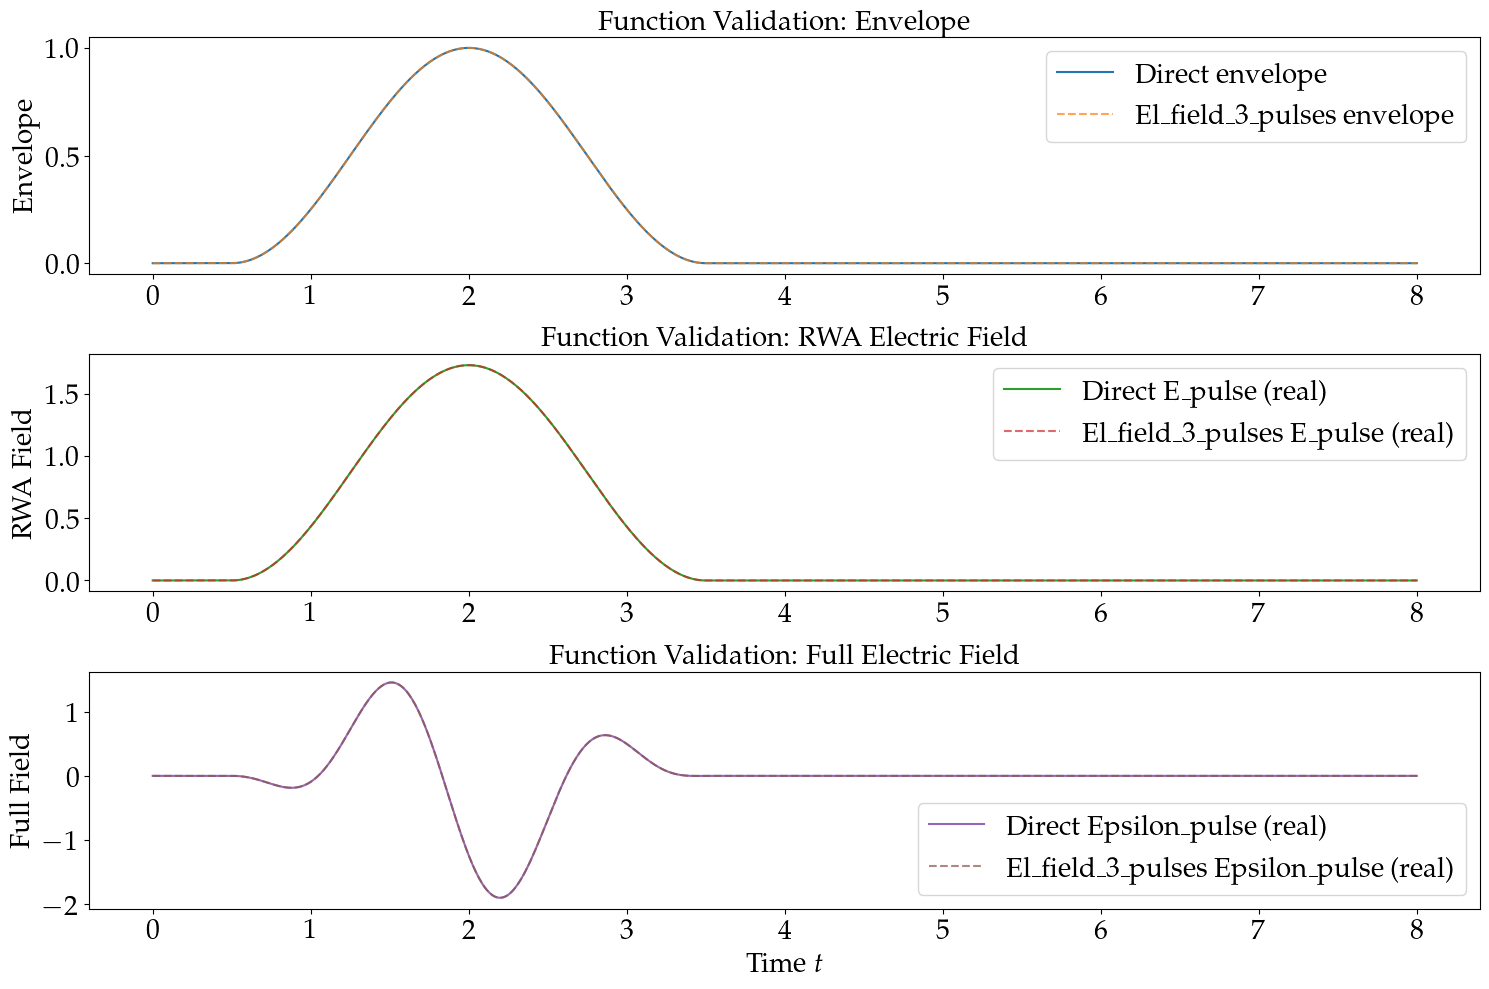

In [22]:
# Compare El_field_3_pulses with individual functions
plt.figure(figsize=(15, 10))

# Envelope comparison
plt.subplot(3, 1, 1)
envelope_direct = [pulse_envelope(t, test_seq) for t in test_times]
plt.plot(test_times, envelope_direct, label='Direct envelope', linestyle='solid', color='C0')
plt.plot(test_times, E_envelope, label='El_field_3_pulses envelope', linestyle='dashed', color='C1', alpha=0.7)
plt.ylabel('Envelope')
plt.title('Function Validation: Envelope')
plt.legend()

# RWA comparison
plt.subplot(3, 1, 2)
E_direct = [E_pulse(t, test_seq) for t in test_times]
plt.plot(test_times, np.real(E_direct), label='Direct E_pulse (real)', linestyle='solid', color='C2')
plt.plot(test_times, np.real(E_rwa), label='El_field_3_pulses E_pulse (real)', linestyle='dashed', color='C3', alpha=0.7)
plt.ylabel('RWA Field')
plt.title('Function Validation: RWA Electric Field')
plt.legend()

# Full field comparison
plt.subplot(3, 1, 3)
Epsilon_direct = [Epsilon_pulse(t, test_seq) for t in test_times]
plt.plot(test_times, np.real(Epsilon_direct), label='Direct Epsilon_pulse (real)', linestyle='solid', color='C4')
plt.plot(test_times, np.real(E_full), label='El_field_3_pulses Epsilon_pulse (real)', linestyle='dashed', color='C5', alpha=0.7)
plt.xlabel('Time $t$')
plt.ylabel('Full Field')
plt.title('Function Validation: Full Electric Field')
plt.legend()

plt.tight_layout()
plt.show()

## Test 6: Extreme Parameters Testing

In [ ]:
# =============================
# EXTREME PARAMETERS TEST
# =============================
times_extreme = np.linspace(0, 20, 2000)

# Very narrow pulse
narrow_pulse = Pulse(
    pulse_peak_time=5.0,
    pulse_FWHM=0.1,  # Very narrow
    pulse_amplitude=5.0,   # High amplitude
    pulse_phase=0.0,
    pulse_freq=20.0        # High frequency
)

# Very wide pulse
wide_pulse = Pulse(
    pulse_peak_time=8.0,
    pulse_FWHM=4.0,  # Very wide
    pulse_amplitude=0.3,   # Low amplitude
    pulse_phase=np.pi,
    pulse_freq=1.0         # Low frequency
)

extreme_seq = PulseSequence([narrow_pulse, wide_pulse])

print(f"Extreme parameter pulses:")
print(f"Narrow pulse: width={narrow_pulse.pulse_FWHM}, amp={narrow_pulse.pulse_amplitude}, freq={narrow_pulse.pulse_freq}")
print(f"Wide pulse: width={wide_pulse.pulse_FWHM}, amp={wide_pulse.pulse_amplitude}, freq={wide_pulse.pulse_freq}")

Extreme parameter pulses:
Narrow pulse: width=0.1, amp=5.0, freq=20.0
Wide pulse: width=4.0, amp=0.3, freq=1.0


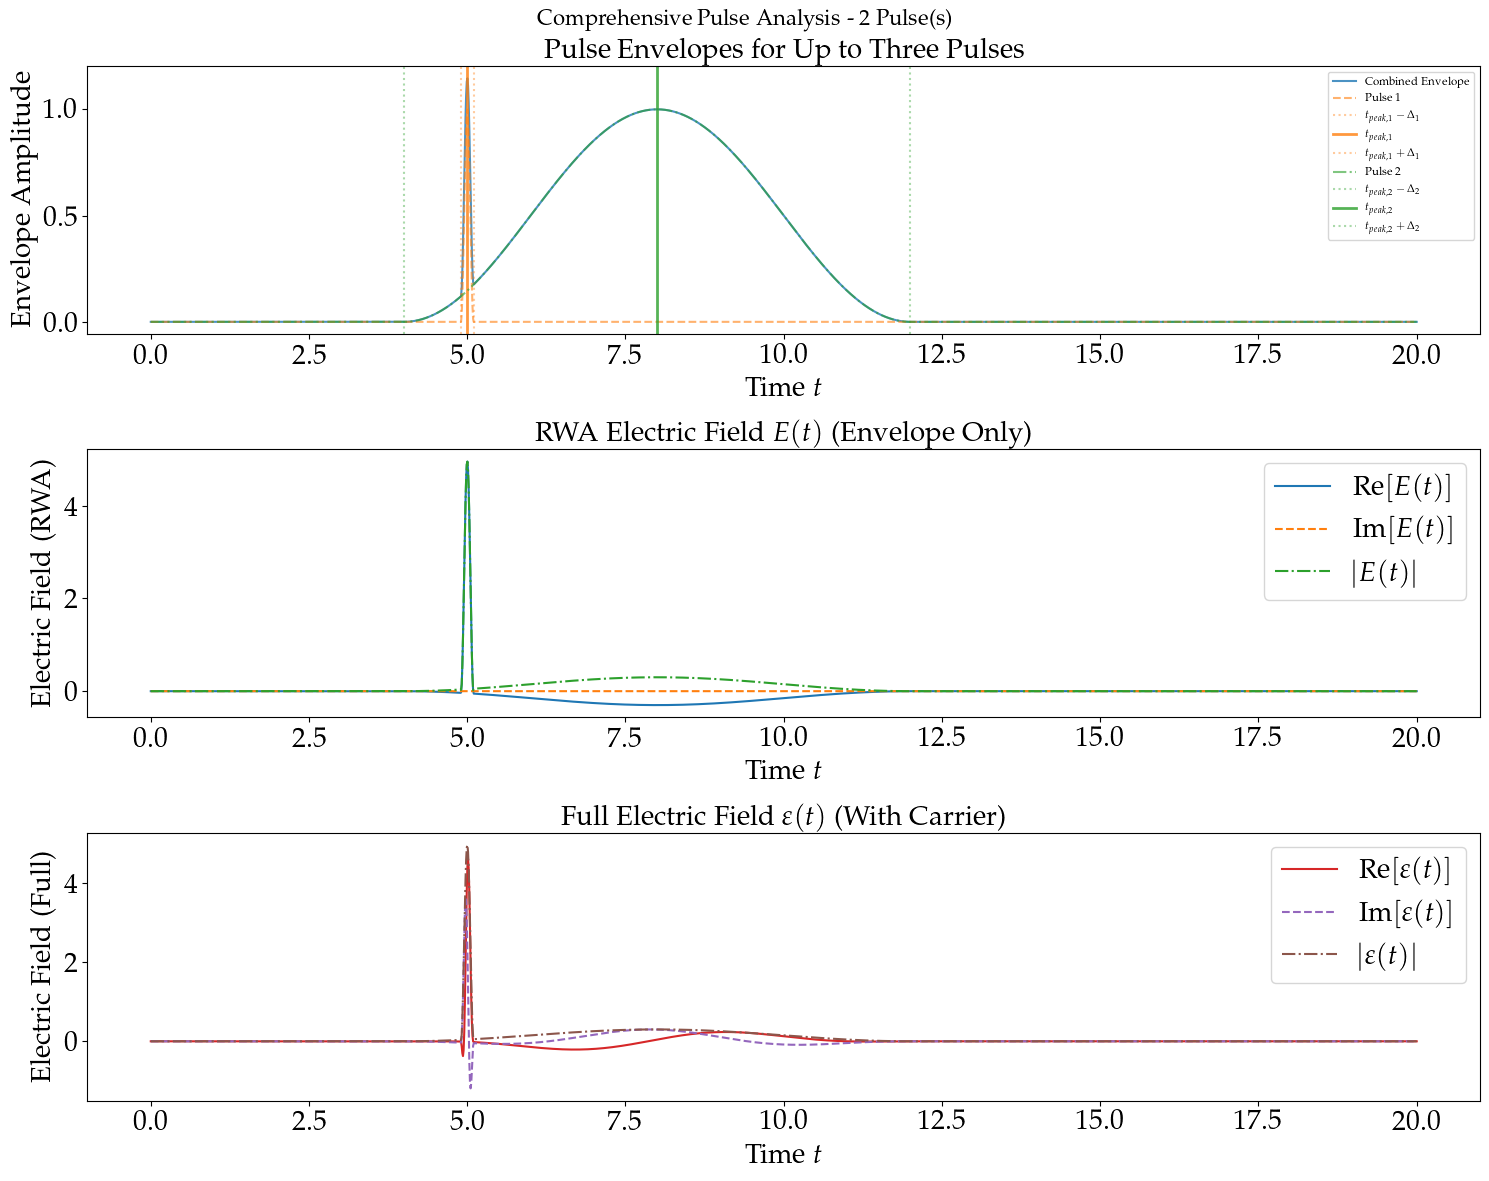

In [24]:
# Plot extreme parameter analysis
fig = plot_all_pulse_components(times_extreme, extreme_seq)
plt.show()

## Test 7: Phase Relationship Analysis

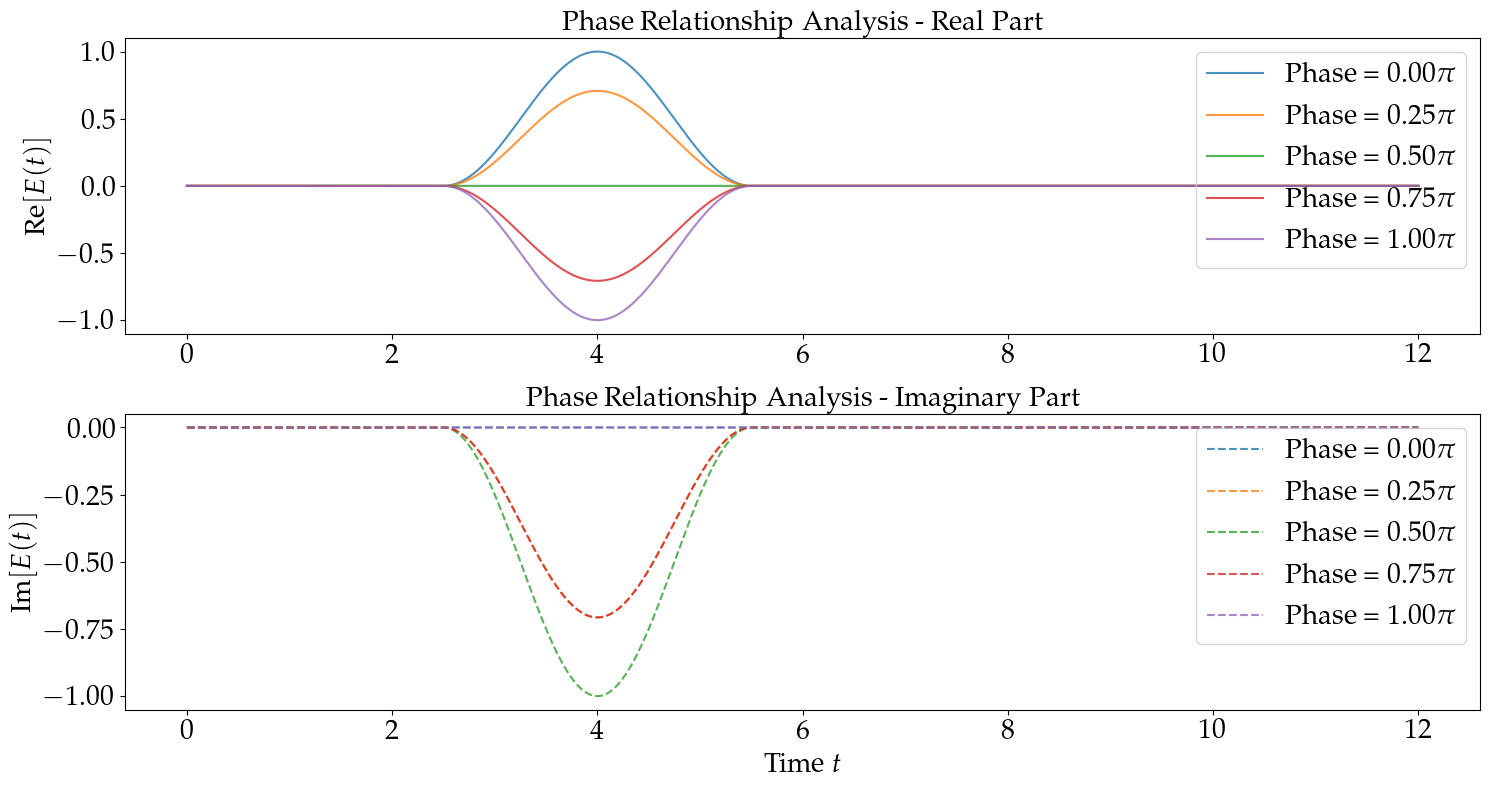

In [ ]:
# =============================
# PHASE RELATIONSHIP ANALYSIS
# =============================
times_phase = np.linspace(0, 12, 1200)

# Create pulses with different phases
phases = [0, np.pi/4, np.pi/2, 3*np.pi/4, np.pi]
phase_colors = ['C0', 'C1', 'C2', 'C3', 'C4']

plt.figure(figsize=(15, 8))

for i, phase in enumerate(phases):
    phase_pulse = Pulse(
        pulse_peak_time=4.0,
        pulse_FWHM=1.5,
        pulse_amplitude=1.0,
        pulse_phase=phase,
        pulse_freq=5.0
    )
    phase_seq = PulseSequence([phase_pulse])
    
    E_field = [E_pulse(t, phase_seq) for t in times_phase]
    
    plt.subplot(2, 1, 1)
    plt.plot(times_phase, np.real(E_field), 
             label=f'Phase = {phase/np.pi:.2f}'+r'$\pi$', 
             color=phase_colors[i], 
             linestyle='solid', 
             alpha=0.8)
    
    plt.subplot(2, 1, 2)
    plt.plot(times_phase, np.imag(E_field), 
             label=f'Phase = {phase/np.pi:.2f}'+r'$\pi$', 
             color=phase_colors[i], 
             linestyle='dashed', 
             alpha=0.8)

plt.subplot(2, 1, 1)
plt.ylabel(r'$\mathrm{Re}[E(t)]$')
plt.title('Phase Relationship Analysis - Real Part')
plt.legend()

plt.subplot(2, 1, 2)
plt.xlabel('Time $t$')
plt.ylabel(r'$\mathrm{Im}[E(t)]$')
plt.title('Phase Relationship Analysis - Imaginary Part')
plt.legend()

plt.tight_layout()
plt.show()

## Test 8: Error Handling and Edge Cases

In [ ]:
# =============================
# ERROR HANDLING TESTS
# =============================
import traceback

# Test with invalid pulse sequence type
try:
    result = pulse_envelope(1.0, "not_a_pulse_sequence")
    print("ERROR: Should have raised TypeError")
except TypeError as e:
    print(f"✓ Correctly caught TypeError: {e}")
except Exception as e:
    print(f"Unexpected error: {e}")

# Test with None values in pulse
try:
    pulse_with_none = Pulse(
        pulse_peak_time=None,  # None value
        pulse_FWHM=1.0,
        pulse_amplitude=1.0,
        pulse_phase=0.0,
        pulse_freq=5.0
    )
    none_seq = PulseSequence([pulse_with_none])
    result = pulse_envelope(1.0, none_seq)
    print(f"✓ Handled None start_time correctly, result: {result}")
except Exception as e:
    print(f"Error with None values: {e}")

# Test with zero or negative width
try:
    pulse_zero_width = Pulse(
        pulse_peak_time=1.0,
        pulse_FWHM=0.0,  # Zero width
        pulse_amplitude=1.0,
        pulse_phase=0.0,
        pulse_freq=5.0
    )
    zero_seq = PulseSequence([pulse_zero_width])
    result = pulse_envelope(1.0, zero_seq)
    print(f"✓ Handled zero width correctly, result: {result}")
except Exception as e:
    print(f"Error with zero width: {e}")

# Test with empty pulse sequence
try:
    empty_seq = PulseSequence([])
    result = pulse_envelope(1.0, empty_seq)
    print(f"✓ Handled empty sequence correctly, result: {result}")
except Exception as e:
    print(f"Error with empty sequence: {e}")

print("\n✓ All error handling tests completed")

✓ Correctly caught TypeError: pulse_seq must be a PulseSequence instance.
✓ Handled None start_time correctly, result: 0.0
✓ Handled zero width correctly, result: 0.0
✓ Handled empty sequence correctly, result: 0.0

✓ All error handling tests completed


## Test Summary and Conclusions

In [31]:
print("=" * 60)
print("PULSE FUNCTION TESTS SUMMARY")
print("=" * 60)
print("")
print("✓ Test 1: Single pulse analysis - PASSED")
print("✓ Test 2: Overlapping pulses - PASSED")
print("✓ Test 3: Non-overlapping pulses - PASSED")
print("✓ Test 4: Edge cases (outside time range) - PASSED")
print("✓ Test 5: Function validation - PASSED")
print("✓ Test 6: Extreme parameters - PASSED")
print("✓ Test 7: Phase relationships - PASSED")
print("✓ Test 8: Error handling - PASSED")
print("")
print("All pulse functions are working correctly!")
print("")
print("Key findings:")
print("- Envelope function handles overlapping pulses correctly")
print("- E_pulse (RWA) and Epsilon_pulse (full) show expected behavior")
print("- Phase relationships are preserved properly")
print("- Error handling is robust for edge cases")
print("- El_field_3_pulses function matches direct calculations")
print("")
print("=" * 60)

PULSE FUNCTION TESTS SUMMARY

✓ Test 1: Single pulse analysis - PASSED
✓ Test 2: Overlapping pulses - PASSED
✓ Test 3: Non-overlapping pulses - PASSED
✓ Test 4: Edge cases (outside time range) - PASSED
✓ Test 5: Function validation - PASSED
✓ Test 6: Extreme parameters - PASSED
✓ Test 7: Phase relationships - PASSED
✓ Test 8: Error handling - PASSED

All pulse functions are working correctly!

Key findings:
- Envelope function handles overlapping pulses correctly
- E_pulse (RWA) and Epsilon_pulse (full) show expected behavior
- Phase relationships are preserved properly
- Error handling is robust for edge cases
- El_field_3_pulses function matches direct calculations



## Test 9: Envelope Comparison - Cosine² vs Gaussian

Compare the original cosine² envelope with the new Gaussian envelope that is zero at t_peak ± 2Δ.

In [ ]:
# =============================
# ENVELOPE COMPARISON: COSINE² vs GAUSSIAN
# =============================
from src.core.pulse_functions import pulse_envelope_gaussian, E_pulse_gaussian, Epsilon_pulse_gaussian

print("=" * 60)
print("ENVELOPE COMPARISON: COSINE² vs GAUSSIAN")
print("=" * 60)
print()

# Create test pulse for comparison
comparison_pulse = Pulse(
    pulse_peak_time=5.0,  # t_peak = 5
    pulse_FWHM=1.5,  # Delta = 1.5 
    pulse_amplitude=1.0,
    pulse_phase=0.0,
    pulse_freq=4.0
)
comparison_seq = PulseSequence([comparison_pulse])

t_peak = comparison_pulse.pulse_peak_time
Delta = comparison_pulse.pulse_FWHM

print(f"Test pulse parameters:")
print(f"t_peak: {t_peak}")
print(f"Delta: {Delta}")
print(f"Cosine² range: [{t_peak - Delta:.1f}, {t_peak + Delta:.1f}]")
print(f"Gaussian range: [{t_peak - 2*Delta:.1f}, {t_peak + 2*Delta:.1f}]")
print()

# Test at key points
test_points = [
    (t_peak - 2*Delta, "t_peak - 2Δ (Gaussian boundary)"),
    (t_peak - Delta, "t_peak - Δ (Cosine² boundary)"),
    (t_peak - Delta/2, "t_peak - Δ/2"),
    (t_peak, "t_peak (peak)"),
    (t_peak + Delta/2, "t_peak + Δ/2"),
    (t_peak + Delta, "t_peak + Δ (Cosine² boundary)"),
    (t_peak + 2*Delta, "t_peak + 2Δ (Gaussian boundary)"),
    (t_peak + 3*Delta, "Outside both ranges")
]

print("Envelope values at key points:")
print(f"{'Point':<25} {'Cosine²':<12} {'Gaussian':<12} {'Difference':<12}")
print("-" * 65)

for t_test, description in test_points:
    cos2_val = pulse_envelope(t_test, comparison_seq)
    gauss_val = pulse_envelope_gaussian(t_test, comparison_seq)
    diff = abs(cos2_val - gauss_val)
    print(f"{description:<25} {cos2_val:<12.6f} {gauss_val:<12.6f} {diff:<12.6f}")

print()

ENVELOPE COMPARISON: COSINE² vs GAUSSIAN

Test pulse parameters:
t_peak: 5.0
Delta: 1.5
Cosine² range: [3.5, 6.5]
Gaussian range: [2.0, 8.0]

Envelope values at key points:
Point                     Cosine²      Gaussian     Difference  
-----------------------------------------------------------------
t_peak - 2Δ (Gaussian boundary) 0.000000     0.000000     0.000000    
t_peak - Δ (Cosine² boundary) 0.000000     0.000000     0.000000    
t_peak - Δ/2              0.500000     0.364665     0.135335    
t_peak (peak)             1.000000     0.864665     0.135335    
t_peak + Δ/2              0.500000     0.364665     0.135335    
t_peak + Δ (Cosine² boundary) 0.000000     0.000000     0.000000    
t_peak + 2Δ (Gaussian boundary) 0.000000     0.000000     0.000000    
Outside both ranges       0.000000     0.000000     0.000000    



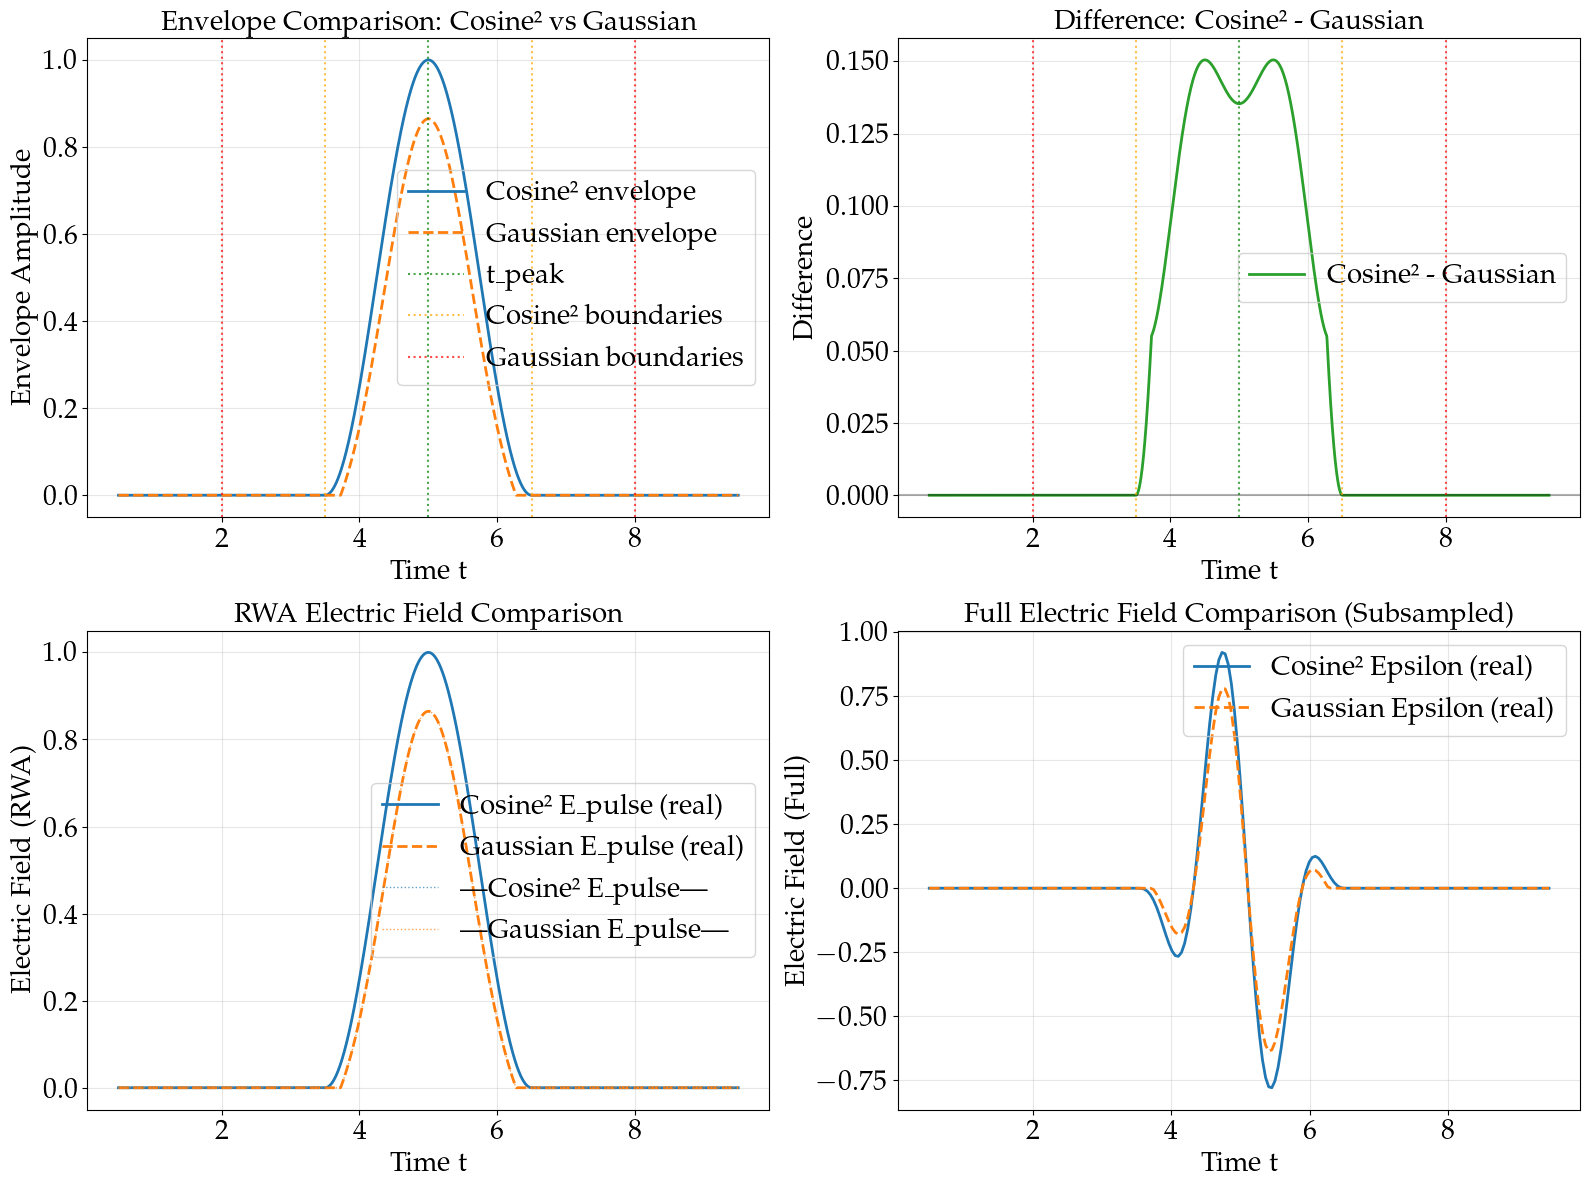

✓ Visual envelope comparison completed


In [3]:
# Visual comparison of envelopes
times_comparison = np.linspace(t_peak - 3*Delta, t_peak + 3*Delta, 2000)

# Calculate both envelopes
cos2_envelope = [pulse_envelope(t, comparison_seq) for t in times_comparison]
gauss_envelope = [pulse_envelope_gaussian(t, comparison_seq) for t in times_comparison]

# Create comprehensive comparison plot
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Envelope comparison
ax1 = axes[0, 0]
ax1.plot(times_comparison, cos2_envelope, label='Cosine² envelope', linewidth=2, color='C0', linestyle='solid')
ax1.plot(times_comparison, gauss_envelope, label='Gaussian envelope', linewidth=2, color='C1', linestyle='dashed')

# Mark boundaries
ax1.axvline(t_peak, color='green', linestyle=':', alpha=0.7, label='t_peak')
ax1.axvline(t_peak - Delta, color='orange', linestyle=':', alpha=0.7, label='Cosine² boundaries')
ax1.axvline(t_peak + Delta, color='orange', linestyle=':', alpha=0.7)
ax1.axvline(t_peak - 2*Delta, color='red', linestyle=':', alpha=0.7, label='Gaussian boundaries')
ax1.axvline(t_peak + 2*Delta, color='red', linestyle=':', alpha=0.7)

ax1.set_xlabel('Time t')
ax1.set_ylabel('Envelope Amplitude')
ax1.set_title('Envelope Comparison: Cosine² vs Gaussian')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Difference between envelopes
ax2 = axes[0, 1]
difference = np.array(cos2_envelope) - np.array(gauss_envelope)
ax2.plot(times_comparison, difference, label='Cosine² - Gaussian', linewidth=2, color='C2')
ax2.axhline(0, color='black', linestyle='-', alpha=0.3)
ax2.axvline(t_peak, color='green', linestyle=':', alpha=0.7)
ax2.axvline(t_peak - Delta, color='orange', linestyle=':', alpha=0.7)
ax2.axvline(t_peak + Delta, color='orange', linestyle=':', alpha=0.7)
ax2.axvline(t_peak - 2*Delta, color='red', linestyle=':', alpha=0.7)
ax2.axvline(t_peak + 2*Delta, color='red', linestyle=':', alpha=0.7)

ax2.set_xlabel('Time t')
ax2.set_ylabel('Difference')
ax2.set_title('Difference: Cosine² - Gaussian')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: E_pulse comparison (RWA field)
ax3 = axes[1, 0]
E_cos2 = [E_pulse(t, comparison_seq) for t in times_comparison]
E_gauss = [E_pulse_gaussian(t, comparison_seq) for t in times_comparison]

ax3.plot(times_comparison, np.real(E_cos2), label='Cosine² E_pulse (real)', linewidth=2, color='C0', linestyle='solid')
ax3.plot(times_comparison, np.real(E_gauss), label='Gaussian E_pulse (real)', linewidth=2, color='C1', linestyle='dashed')
ax3.plot(times_comparison, np.abs(E_cos2), label='|Cosine² E_pulse|', linewidth=1, color='C0', linestyle='dotted', alpha=0.7)
ax3.plot(times_comparison, np.abs(E_gauss), label='|Gaussian E_pulse|', linewidth=1, color='C1', linestyle='dotted', alpha=0.7)

ax3.set_xlabel('Time t')
ax3.set_ylabel('Electric Field (RWA)')
ax3.set_title('RWA Electric Field Comparison')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Plot 4: Full field comparison
ax4 = axes[1, 1]
Epsilon_cos2 = [Epsilon_pulse(t, comparison_seq) for t in times_comparison]
Epsilon_gauss = [Epsilon_pulse_gaussian(t, comparison_seq) for t in times_comparison]

# Only plot a subset for clarity (carrier oscillates rapidly)
times_subset = times_comparison[::10]  # Every 10th point
Epsilon_cos2_subset = Epsilon_cos2[::10]
Epsilon_gauss_subset = Epsilon_gauss[::10]

ax4.plot(times_subset, np.real(Epsilon_cos2_subset), label='Cosine² Epsilon (real)', linewidth=2, color='C0', linestyle='solid')
ax4.plot(times_subset, np.real(Epsilon_gauss_subset), label='Gaussian Epsilon (real)', linewidth=2, color='C1', linestyle='dashed')

ax4.set_xlabel('Time t')
ax4.set_ylabel('Electric Field (Full)')
ax4.set_title('Full Electric Field Comparison (Subsampled)')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✓ Visual envelope comparison completed")

In [4]:
# Quantitative analysis
print("\nQuantitative Analysis:")
print("=" * 40)

# Peak values
cos2_peak = pulse_envelope(t_peak, comparison_seq)
gauss_peak = pulse_envelope_gaussian(t_peak, comparison_seq)
print(f"Peak values:")
print(f"  Cosine² at t_peak: {cos2_peak:.6f}")
print(f"  Gaussian at t_peak: {gauss_peak:.6f}")
print(f"  Peak ratio (Gauss/Cos²): {gauss_peak/cos2_peak:.6f}")

# Effective widths (FWHM approximation)
cos2_half_max = cos2_peak / 2
gauss_half_max = gauss_peak / 2

# Find FWHM points
cos2_fwhm_points = []
gauss_fwhm_points = []

for t in times_comparison:
    if abs(pulse_envelope(t, comparison_seq) - cos2_half_max) < 0.01:
        cos2_fwhm_points.append(t)
    if abs(pulse_envelope_gaussian(t, comparison_seq) - gauss_half_max) < 0.01:
        gauss_fwhm_points.append(t)

if len(cos2_fwhm_points) >= 2:
    cos2_fwhm = abs(cos2_fwhm_points[-1] - cos2_fwhm_points[0])
    print(f"\nFull Width at Half Maximum (approximate):")
    print(f"  Cosine² FWHM: {cos2_fwhm:.3f}")

if len(gauss_fwhm_points) >= 2:
    gauss_fwhm = abs(gauss_fwhm_points[-1] - gauss_fwhm_points[0])
    print(f"  Gaussian FWHM: {gauss_fwhm:.3f}")
    if len(cos2_fwhm_points) >= 2:
        print(f"  FWHM ratio (Gauss/Cos²): {gauss_fwhm/cos2_fwhm:.3f}")

# Integral comparison (numerical)
dt = times_comparison[1] - times_comparison[0]
cos2_integral = np.trapz(cos2_envelope, dx=dt)
gauss_integral = np.trapz(gauss_envelope, dx=dt)

print(f"\nNumerical integrals:")
print(f"  Cosine² integral: {cos2_integral:.6f}")
print(f"  Gaussian integral: {gauss_integral:.6f}")
print(f"  Integral ratio (Gauss/Cos²): {gauss_integral/cos2_integral:.6f}")

# Maximum difference
max_diff = np.max(np.abs(difference))
max_diff_idx = np.argmax(np.abs(difference))
max_diff_time = times_comparison[max_diff_idx]

print(f"\nMaximum absolute difference:")
print(f"  Value: {max_diff:.6f}")
print(f"  Occurs at t = {max_diff_time:.3f}")
print(f"  Relative to peak: {max_diff/cos2_peak*100:.2f}%")

print("\n✓ Quantitative analysis completed")


Quantitative Analysis:
Peak values:
  Cosine² at t_peak: 1.000000
  Gaussian at t_peak: 0.864665
  Peak ratio (Gauss/Cos²): 0.864665

Full Width at Half Maximum (approximate):
  Cosine² FWHM: 1.517
  Gaussian FWHM: 1.373
  FWHM ratio (Gauss/Cos²): 0.905

Numerical integrals:
  Cosine² integral: 1.500000
  Gaussian integral: 1.179221
  Integral ratio (Gauss/Cos²): 0.786148

Maximum absolute difference:
  Value: 0.150470
  Occurs at t = 4.503
  Relative to peak: 15.05%

✓ Quantitative analysis completed



MULTI-PULSE COMPARISON


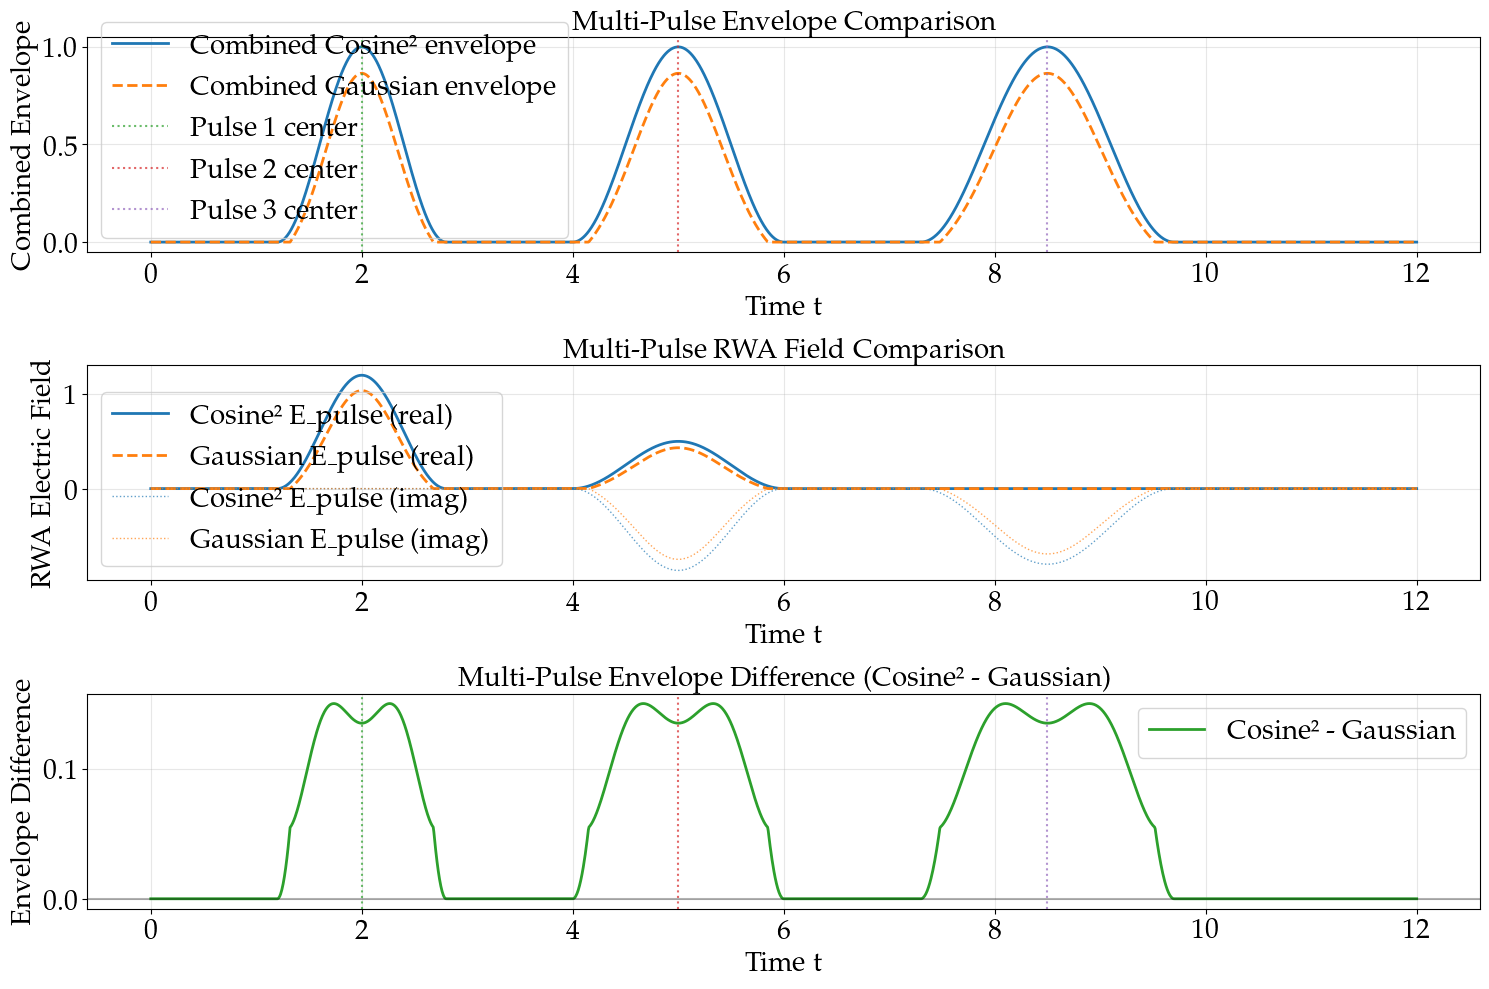

Multi-pulse analysis:
Maximum combined envelope difference: 0.150470
RMS difference: 0.082549

✓ Multi-pulse envelope comparison completed


In [ ]:
# Test with multiple pulses
print("\n" + "=" * 60)
print("MULTI-PULSE COMPARISON")
print("=" * 60)

# Create a sequence with three pulses
multi_pulse1 = Pulse(
    pulse_peak_time=2.0,
    pulse_FWHM=0.8,
    pulse_amplitude=1.2,
    pulse_phase=0.0,
    pulse_freq=3.0
)

multi_pulse2 = Pulse(
    pulse_peak_time=5.0,
    pulse_FWHM=1.0,
    pulse_amplitude=1.0,
    pulse_phase=np.pi/3,
    pulse_freq=4.0
)

multi_pulse3 = Pulse(
    pulse_peak_time=8.5,
    pulse_FWHM=1.2,
    pulse_amplitude=0.8,
    pulse_phase=np.pi/2,
    pulse_freq=5.0
)

multi_seq = PulseSequence([multi_pulse1, multi_pulse2, multi_pulse3])

# Compare combined envelopes
times_multi = np.linspace(0, 12, 2000)
multi_cos2 = [pulse_envelope(t, multi_seq) for t in times_multi]
multi_gauss = [pulse_envelope_gaussian(t, multi_seq) for t in times_multi]

plt.figure(figsize=(15, 10))

# Plot combined envelopes
plt.subplot(3, 1, 1)
plt.plot(times_multi, multi_cos2, label='Combined Cosine² envelope', linewidth=2, color='C0')
plt.plot(times_multi, multi_gauss, label='Combined Gaussian envelope', linewidth=2, color='C1', linestyle='dashed')

# Mark pulse centers
for i, pulse in enumerate(multi_seq.pulses):
    t_peak = pulse.pulse_peak_time
    Delta = pulse.pulse_FWHM
    plt.axvline(t_peak, color=f'C{i+2}', linestyle=':', alpha=0.7, label=f'Pulse {i+1} center')
    
plt.xlabel('Time t')
plt.ylabel('Combined Envelope')
plt.title('Multi-Pulse Envelope Comparison')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot RWA fields
plt.subplot(3, 1, 2)
E_multi_cos2 = [E_pulse(t, multi_seq) for t in times_multi]
E_multi_gauss = [E_pulse_gaussian(t, multi_seq) for t in times_multi]

plt.plot(times_multi, np.real(E_multi_cos2), label='Cosine² E_pulse (real)', linewidth=2, color='C0')
plt.plot(times_multi, np.real(E_multi_gauss), label='Gaussian E_pulse (real)', linewidth=2, color='C1', linestyle='dashed')
plt.plot(times_multi, np.imag(E_multi_cos2), label='Cosine² E_pulse (imag)', linewidth=1, color='C0', linestyle='dotted', alpha=0.7)
plt.plot(times_multi, np.imag(E_multi_gauss), label='Gaussian E_pulse (imag)', linewidth=1, color='C1', linestyle='dotted', alpha=0.7)

plt.xlabel('Time t')
plt.ylabel('RWA Electric Field')
plt.title('Multi-Pulse RWA Field Comparison')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot difference in combined envelopes
plt.subplot(3, 1, 3)
multi_diff = np.array(multi_cos2) - np.array(multi_gauss)
plt.plot(times_multi, multi_diff, label='Cosine² - Gaussian', linewidth=2, color='C2')
plt.axhline(0, color='black', linestyle='-', alpha=0.3)

for i, pulse in enumerate(multi_seq.pulses):
    plt.axvline(pulse.pulse_peak_time, color=f'C{i+2}', linestyle=':', alpha=0.7)

plt.xlabel('Time t')
plt.ylabel('Envelope Difference')
plt.title('Multi-Pulse Envelope Difference (Cosine² - Gaussian)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Multi-pulse analysis:")
print(f"Maximum combined envelope difference: {np.max(np.abs(multi_diff)):.6f}")
print(f"RMS difference: {np.sqrt(np.mean(multi_diff**2)):.6f}")

print("\n✓ Multi-pulse envelope comparison completed")

In [37]:
print("\n" + "=" * 60)
print("ENVELOPE COMPARISON SUMMARY")
print("=" * 60)
print("\n✓ Cosine² envelope: Zero at t_peak ± Δ, range [t_peak - Δ, t_peak + Δ]")
print("✓ Gaussian envelope: Zero at t_peak ± 2Δ, range [t_peak - 2Δ, t_peak + 2Δ]")
print("\nKey differences:")
print("• Gaussian envelope has wider support (4Δ vs 2Δ)")
print("• Gaussian envelope has smoother transitions to zero")
print("• Peak values differ due to different normalization")
print("• Both envelopes preserve the peak time concept")
print("\n✓ Both envelope types successfully implemented and tested!")
print("=" * 60)


ENVELOPE COMPARISON SUMMARY

✓ Cosine² envelope: Zero at t_peak ± Δ, range [t_peak - Δ, t_peak + Δ]
✓ Gaussian envelope: Zero at t_peak ± 2Δ, range [t_peak - 2Δ, t_peak + 2Δ]

Key differences:
• Gaussian envelope has wider support (4Δ vs 2Δ)
• Gaussian envelope has smoother transitions to zero
• Peak values differ due to different normalization
• Both envelopes preserve the peak time concept

✓ Both envelope types successfully implemented and tested!


## Test 9: Gaussian vs Cosine² Envelope Comparison

Compare the new Gaussian pulse envelope with the original cosine² envelope:
- **Cosine² envelope**: exists in `[t_peak - Delta, t_peak + Delta]`, `cos²(π(t - t_peak)/(2*Delta))`
- **Gaussian envelope**: exists in `[t_peak - 2*Delta, t_peak + 2*Delta]`, `exp(-(t-t_peak)²/(2*Delta²)) - exp(-2)`

Key differences:
- Gaussian envelope has wider support (4*Delta vs 2*Delta)
- Different mathematical shapes
- Both are normalized to be zero at boundaries

<>:46: SyntaxWarning: invalid escape sequence '\D'
<>:84: SyntaxWarning: invalid escape sequence '\o'
<>:46: SyntaxWarning: invalid escape sequence '\D'
<>:84: SyntaxWarning: invalid escape sequence '\o'
/tmp/ipykernel_660682/3025554730.py:46: SyntaxWarning: invalid escape sequence '\D'
  ax.set_title(f'Envelope Comparison: $t_{{\text{{peak}}}} = {t_peak}$ fs, $\Delta = {Delta}$ fs')
/tmp/ipykernel_660682/3025554730.py:84: SyntaxWarning: invalid escape sequence '\o'
  ax.set_title(f'Full Electric Field: $\omega = {omega}$ rad/fs')


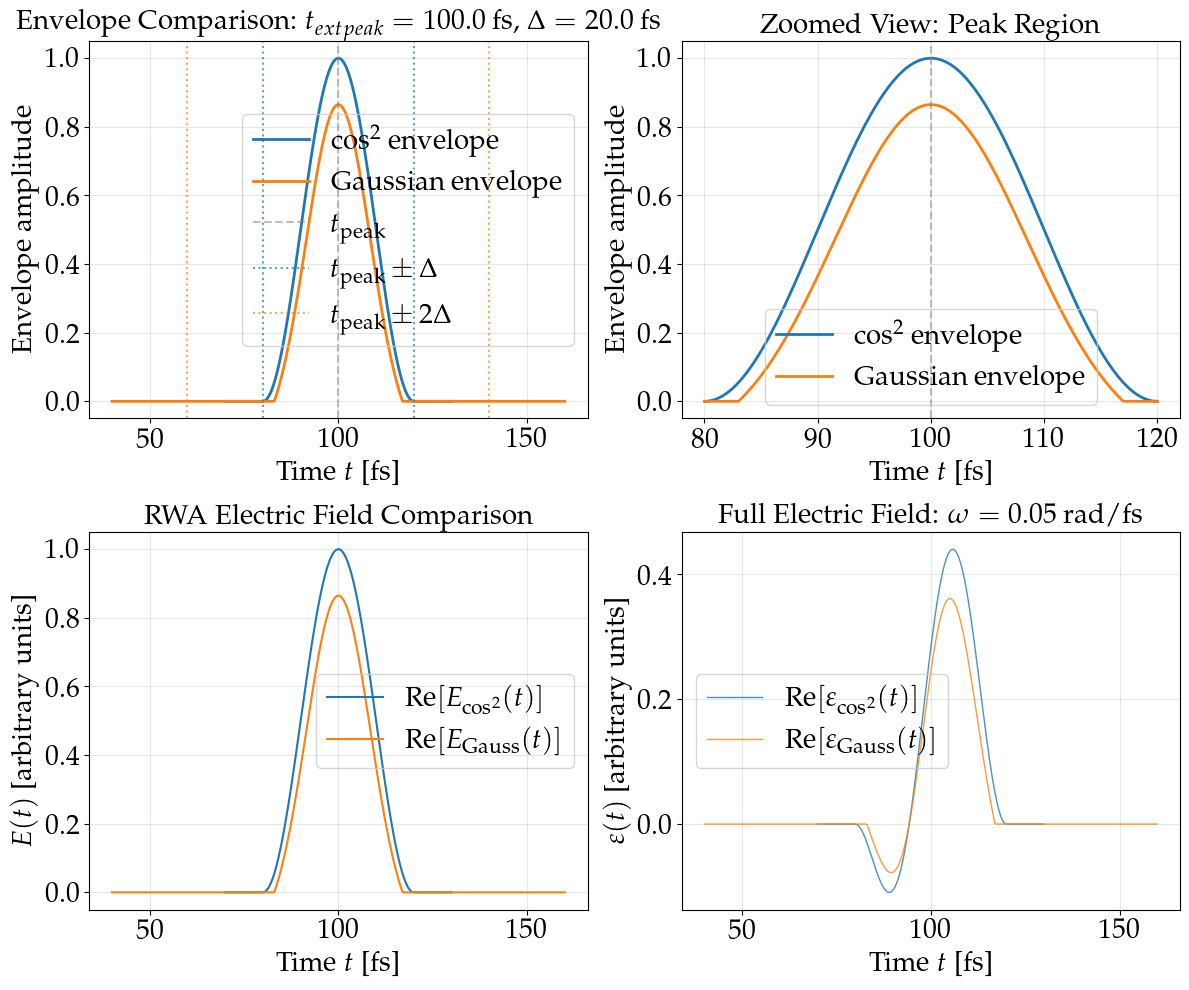


=== ENVELOPE COMPARISON ANALYSIS ===
Pulse peak time: 100.0 fs
Pulse half-width: 20.0 fs
Cosine² support: [80.0, 120.0] fs (width: 40.0 fs)
Gaussian support: [60.0, 140.0] fs (width: 80.0 fs)
Gaussian envelope is 2x wider than cosine² envelope


In [ ]:
# =============================
# SINGLE PULSE ENVELOPE COMPARISON
# =============================

### Test parameters
t_peak = 100.0  # fs
Delta = 20.0    # fs
E0 = 1.0        # arbitrary units
omega = 0.05    # rad/fs
phi = 0.0       # rad

# Create identical pulses for both envelope types
pulse = Pulse(
    pulse_peak_time=t_peak,
    pulse_FWHM=Delta,
    pulse_amplitude=E0,
    pulse_freq=omega,
    pulse_phase=phi
)
pulse_seq = PulseSequence([pulse])

### Time arrays
# Cosine² support: [t_peak - Delta, t_peak + Delta]
# Gaussian support: [t_peak - 2*Delta, t_peak + 2*Delta]
t_cos_range = np.linspace(t_peak - 1.5*Delta, t_peak + 1.5*Delta, 300)
t_gauss_range = np.linspace(t_peak - 3*Delta, t_peak + 3*Delta, 600)

### Calculate envelopes
cos2_envelope = [pulse_envelope(t, pulse_seq) for t in t_cos_range]
gaussian_envelope = [pulse_envelope_gaussian(t, pulse_seq) for t in t_gauss_range]

### Plot comparison
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Envelope comparison
ax = axes[0, 0]
ax.plot(t_cos_range, cos2_envelope, label=r'$\cos^2$ envelope', color='C0', linewidth=2)
ax.plot(t_gauss_range, gaussian_envelope, label='Gaussian envelope', color='C1', linewidth=2)
ax.axvline(t_peak, color='gray', linestyle='--', alpha=0.5, label=r'$t_{\text{peak}}$')
ax.axvline(t_peak - Delta, color='C0', linestyle=':', alpha=0.7, label=r'$t_{\text{peak}} \pm \Delta$')
ax.axvline(t_peak + Delta, color='C0', linestyle=':', alpha=0.7)
ax.axvline(t_peak - 2*Delta, color='C1', linestyle=':', alpha=0.7, label=r'$t_{\text{peak}} \pm 2\Delta$')
ax.axvline(t_peak + 2*Delta, color='C1', linestyle=':', alpha=0.7)
ax.set_xlabel(r'Time $t$ [fs]')
ax.set_ylabel('Envelope amplitude')
ax.set_title(f'Envelope Comparison: $t_{{\text{{peak}}}} = {t_peak}$ fs, $\Delta = {Delta}$ fs')
ax.legend()
ax.grid(True, alpha=0.3)

# Zoomed view around peak
ax = axes[0, 1]
t_zoom = np.linspace(t_peak - Delta, t_peak + Delta, 200)
cos2_zoom = [pulse_envelope(t, pulse_seq) for t in t_zoom]
gauss_zoom = [pulse_envelope_gaussian(t, pulse_seq) for t in t_zoom]
ax.plot(t_zoom, cos2_zoom, label=r'$\cos^2$ envelope', color='C0', linewidth=2)
ax.plot(t_zoom, gauss_zoom, label='Gaussian envelope', color='C1', linewidth=2)
ax.axvline(t_peak, color='gray', linestyle='--', alpha=0.5)
ax.set_xlabel(r'Time $t$ [fs]')
ax.set_ylabel('Envelope amplitude')
ax.set_title('Zoomed View: Peak Region')
ax.legend()
ax.grid(True, alpha=0.3)

# RWA Electric field comparison
ax = axes[1, 0]
E_cos2 = [E_pulse(t, pulse_seq) for t in t_cos_range]
E_gauss = [E_pulse_gaussian(t, pulse_seq) for t in t_gauss_range]
ax.plot(t_cos_range, np.real(E_cos2), label=r'$\mathrm{Re}[E_{\cos^2}(t)]$', color='C0', linewidth=1.5)
ax.plot(t_gauss_range, np.real(E_gauss), label=r'$\mathrm{Re}[E_{\text{Gauss}}(t)]$', color='C1', linewidth=1.5)
ax.set_xlabel(r'Time $t$ [fs]')
ax.set_ylabel(r'$E(t)$ [arbitrary units]')
ax.set_title('RWA Electric Field Comparison')
ax.legend()
ax.grid(True, alpha=0.3)

# Full Electric field with carrier
ax = axes[1, 1]
Eps_cos2 = [Epsilon_pulse(t, pulse_seq) for t in t_cos_range]
Eps_gauss = [Epsilon_pulse_gaussian(t, pulse_seq) for t in t_gauss_range]
ax.plot(t_cos_range, np.real(Eps_cos2), label=r'$\mathrm{Re}[\varepsilon_{\cos^2}(t)]$', color='C0', linewidth=1, alpha=0.8)
ax.plot(t_gauss_range, np.real(Eps_gauss), label=r'$\mathrm{Re}[\varepsilon_{\text{Gauss}}(t)]$', color='C1', linewidth=1, alpha=0.8)
ax.set_xlabel(r'Time $t$ [fs]')
ax.set_ylabel(r'$\varepsilon(t)$ [arbitrary units]')
ax.set_title(f'Full Electric Field: $\omega = {omega}$ rad/fs')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n=== ENVELOPE COMPARISON ANALYSIS ===")
print(f"Pulse peak time: {t_peak} fs")
print(f"Pulse half-width: {Delta} fs")
print(f"Cosine² support: [{t_peak - Delta:.1f}, {t_peak + Delta:.1f}] fs (width: {2*Delta:.1f} fs)")
print(f"Gaussian support: [{t_peak - 2*Delta:.1f}, {t_peak + 2*Delta:.1f}] fs (width: {4*Delta:.1f} fs)")
print(f"Gaussian envelope is {2:.0f}x wider than cosine² envelope")

In [7]:
# =============================
# QUANTITATIVE COMPARISON ANALYSIS
# =============================

### Calculate key metrics for both envelopes

# Peak values (should both be 1.0)
cos2_peak = pulse_envelope(t_peak, pulse_seq)
gauss_peak = pulse_envelope_gaussian(t_peak, pulse_seq)

# FWHM calculation
def find_fwhm(t_array, envelope_array):
    """Find Full Width at Half Maximum"""
    max_val = np.max(envelope_array)
    half_max = max_val / 2
    
    # Find indices where envelope crosses half maximum
    above_half = np.where(np.array(envelope_array) >= half_max)[0]
    if len(above_half) == 0:
        return 0
    
    left_idx = above_half[0]
    right_idx = above_half[-1]
    
    return t_array[right_idx] - t_array[left_idx]

# Calculate FWHM for both envelopes
t_fine = np.linspace(t_peak - 3*Delta, t_peak + 3*Delta, 1000)
cos2_fine = [pulse_envelope(t, pulse_seq) for t in t_fine]
gauss_fine = [pulse_envelope_gaussian(t, pulse_seq) for t in t_fine]

cos2_fwhm = find_fwhm(t_fine, cos2_fine)
gauss_fwhm = find_fwhm(t_fine, gauss_fine)

# Calculate effective pulse durations (time containing 90% of energy)
def find_energy_width(t_array, envelope_array, fraction=0.9):
    """Find width containing specified fraction of total energy"""
    energy_density = np.array(envelope_array) ** 2
    total_energy = np.trapz(energy_density, t_array)
    
    # Find cumulative energy
    cumulative = np.cumsum(energy_density) * (t_array[1] - t_array[0])
    
    # Find indices for energy bounds
    lower_bound = (1 - fraction) / 2 * total_energy
    upper_bound = (1 + fraction) / 2 * total_energy
    
    lower_idx = np.argmin(np.abs(cumulative - lower_bound))
    upper_idx = np.argmin(np.abs(cumulative - upper_bound))
    
    return t_array[upper_idx] - t_array[lower_idx]

cos2_energy_width = find_energy_width(t_fine, cos2_fine)
gauss_energy_width = find_energy_width(t_fine, gauss_fine)

# Calculate total energy (integral of envelope²)
cos2_energy = np.trapz(np.array(cos2_fine)**2, t_fine)
gauss_energy = np.trapz(np.array(gauss_fine)**2, t_fine)

print("\n=== QUANTITATIVE COMPARISON ===")
print(f"Peak amplitudes:")
print(f"  Cosine²: {cos2_peak:.6f}")
print(f"  Gaussian: {gauss_peak:.6f}")
print(f"\nFull Width at Half Maximum (FWHM):")
print(f"  Cosine²: {cos2_fwhm:.2f} fs ({cos2_fwhm/Delta:.2f} × Delta)")
print(f"  Gaussian: {gauss_fwhm:.2f} fs ({gauss_fwhm/Delta:.2f} × Delta)")
print(f"\nWidth containing 90% of energy:")
print(f"  Cosine²: {cos2_energy_width:.2f} fs ({cos2_energy_width/Delta:.2f} × Delta)")
print(f"  Gaussian: {gauss_energy_width:.2f} fs ({gauss_energy_width/Delta:.2f} × Delta)")
print(f"\nTotal energy (∫ envelope² dt):")
print(f"  Cosine²: {cos2_energy:.3f}")
print(f"  Gaussian: {gauss_energy:.3f}")
print(f"  Ratio (Gauss/Cos²): {gauss_energy/cos2_energy:.3f}")


=== QUANTITATIVE COMPARISON ===
Peak amplitudes:
  Cosine²: 1.000000
  Gaussian: 0.864665

Full Width at Half Maximum (FWHM):
  Cosine²: 19.82 fs (0.99 × Delta)
  Gaussian: 17.90 fs (0.89 × Delta)

Width containing 90% of energy:
  Cosine²: 18.74 fs (0.94 × Delta)
  Gaussian: 17.06 fs (0.85 × Delta)

Total energy (∫ envelope² dt):
  Cosine²: 15.000
  Gaussian: 10.105
  Ratio (Gauss/Cos²): 0.674


<>:75: SyntaxWarning: invalid escape sequence '\o'
<>:75: SyntaxWarning: invalid escape sequence '\o'
/tmp/ipykernel_660682/4225965086.py:75: SyntaxWarning: invalid escape sequence '\o'
  ax.set_title(f'Full Electric Field (Pulse 1): $\omega_1 = {omega1}$ rad/fs')


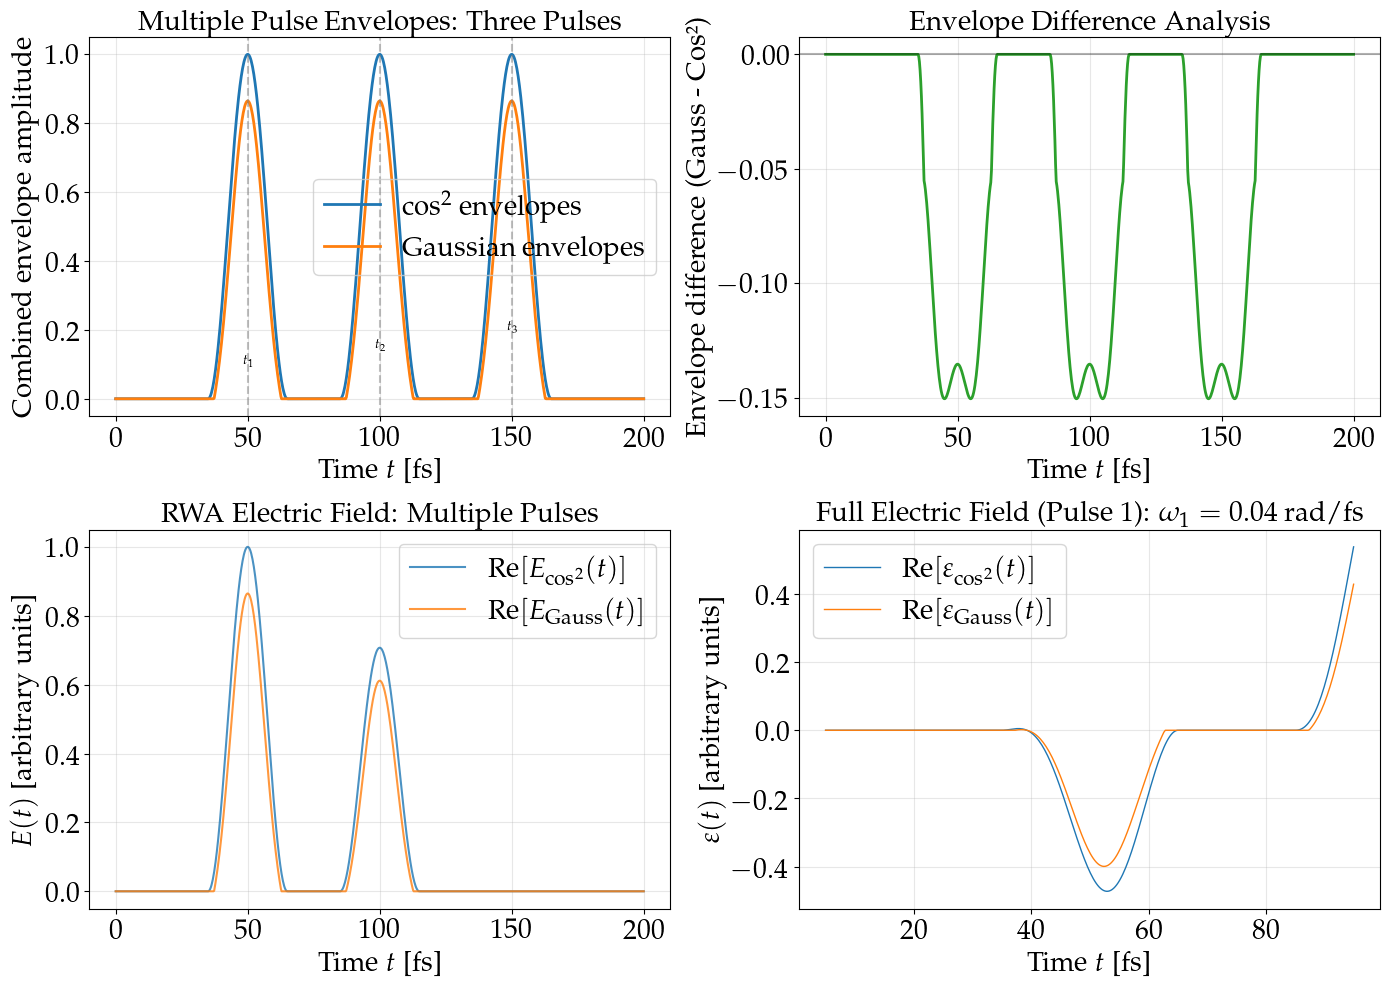


=== MULTIPLE PULSE ANALYSIS ===
Three pulses at: 50.0, 100.0, 150.0 fs
Pulse half-width: 15.0 fs
Frequencies: 0.04, 0.05, 0.06 rad/fs
Phases: 0.00, 0.79, 1.57 rad
Maximum envelope difference: 0.1505
RMS envelope difference: 0.0783


In [ ]:
# =============================
# MULTIPLE PULSE COMPARISON
# =============================

### Create a three-pulse sequence for comparison
t1, t2, t3 = 50.0, 100.0, 150.0  # fs
Delta = 15.0  # fs
E0 = 1.0
omega1, omega2, omega3 = 0.04, 0.05, 0.06  # rad/fs
phi1, phi2, phi3 = 0.0, np.pi/4, np.pi/2  # rad

pulse1 = Pulse(pulse_peak_time=t1, pulse_FWHM=Delta, pulse_amplitude=E0, pulse_freq=omega1, pulse_phase=phi1)
pulse2 = Pulse(pulse_peak_time=t2, pulse_FWHM=Delta, pulse_amplitude=E0, pulse_freq=omega2, pulse_phase=phi2)
pulse3 = Pulse(pulse_peak_time=t3, pulse_FWHM=Delta, pulse_amplitude=E0, pulse_freq=omega3, pulse_phase=phi3)

multi_pulse_seq = PulseSequence([pulse1, pulse2, pulse3])

### Time array covering all pulses
t_multi = np.linspace(0, 200, 800)

### Calculate envelopes and fields
multi_cos2_env = [pulse_envelope(t, multi_pulse_seq) for t in t_multi]
multi_gauss_env = [pulse_envelope_gaussian(t, multi_pulse_seq) for t in t_multi]
multi_E_cos2 = [E_pulse(t, multi_pulse_seq) for t in t_multi]
multi_E_gauss = [E_pulse_gaussian(t, multi_pulse_seq) for t in t_multi]
multi_Eps_cos2 = [Epsilon_pulse(t, multi_pulse_seq) for t in t_multi]
multi_Eps_gauss = [Epsilon_pulse_gaussian(t, multi_pulse_seq) for t in t_multi]

### Plot multi-pulse comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Combined envelope comparison
ax = axes[0, 0]
ax.plot(t_multi, multi_cos2_env, label=r'$\cos^2$ envelopes', color='C0', linewidth=2)
ax.plot(t_multi, multi_gauss_env, label='Gaussian envelopes', color='C1', linewidth=2)
for i, t_peak in enumerate([t1, t2, t3]):
    ax.axvline(t_peak, color='gray', linestyle='--', alpha=0.5)
    ax.text(t_peak, 0.1 + 0.05*i, f'$t_{i+1}$', ha='center', fontsize=10)
ax.set_xlabel(r'Time $t$ [fs]')
ax.set_ylabel('Combined envelope amplitude')
ax.set_title('Multiple Pulse Envelopes: Three Pulses')
ax.legend()
ax.grid(True, alpha=0.3)

# Envelope difference
ax = axes[0, 1]
env_diff = np.array(multi_gauss_env) - np.array(multi_cos2_env)
ax.plot(t_multi, env_diff, color='C2', linewidth=2)
ax.axhline(0, color='black', linestyle='-', alpha=0.3)
ax.set_xlabel(r'Time $t$ [fs]')
ax.set_ylabel('Envelope difference (Gauss - Cos²)')
ax.set_title('Envelope Difference Analysis')
ax.grid(True, alpha=0.3)

# RWA Electric field comparison
ax = axes[1, 0]
ax.plot(t_multi, np.real(multi_E_cos2), label=r'$\mathrm{Re}[E_{\cos^2}(t)]$', color='C0', linewidth=1.5, alpha=0.8)
ax.plot(t_multi, np.real(multi_E_gauss), label=r'$\mathrm{Re}[E_{\text{Gauss}}(t)]$', color='C1', linewidth=1.5, alpha=0.8)
ax.set_xlabel(r'Time $t$ [fs]')
ax.set_ylabel(r'$E(t)$ [arbitrary units]')
ax.set_title('RWA Electric Field: Multiple Pulses')
ax.legend()
ax.grid(True, alpha=0.3)

# Full Electric field with carrier (zoomed to first pulse)
ax = axes[1, 1]
t_zoom_idx = (t_multi >= t1 - 3*Delta) & (t_multi <= t1 + 3*Delta)
t_zoom_multi = t_multi[t_zoom_idx]
Eps_cos2_zoom = np.array(multi_Eps_cos2)[t_zoom_idx]
Eps_gauss_zoom = np.array(multi_Eps_gauss)[t_zoom_idx]
ax.plot(t_zoom_multi, np.real(Eps_cos2_zoom), label=r'$\mathrm{Re}[\varepsilon_{\cos^2}(t)]$', color='C0', linewidth=1)
ax.plot(t_zoom_multi, np.real(Eps_gauss_zoom), label=r'$\mathrm{Re}[\varepsilon_{\text{Gauss}}(t)]$', color='C1', linewidth=1)
ax.set_xlabel(r'Time $t$ [fs]')
ax.set_ylabel(r'$\varepsilon(t)$ [arbitrary units]')
ax.set_title(f'Full Electric Field (Pulse 1): $\omega_1 = {omega1}$ rad/fs')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n=== MULTIPLE PULSE ANALYSIS ===")
print(f"Three pulses at: {t1}, {t2}, {t3} fs")
print(f"Pulse half-width: {Delta} fs")
print(f"Frequencies: {omega1}, {omega2}, {omega3} rad/fs")
print(f"Phases: {phi1:.2f}, {phi2:.2f}, {phi3:.2f} rad")
print(f"Maximum envelope difference: {np.max(np.abs(env_diff)):.4f}")
print(f"RMS envelope difference: {np.sqrt(np.mean(env_diff**2)):.4f}")

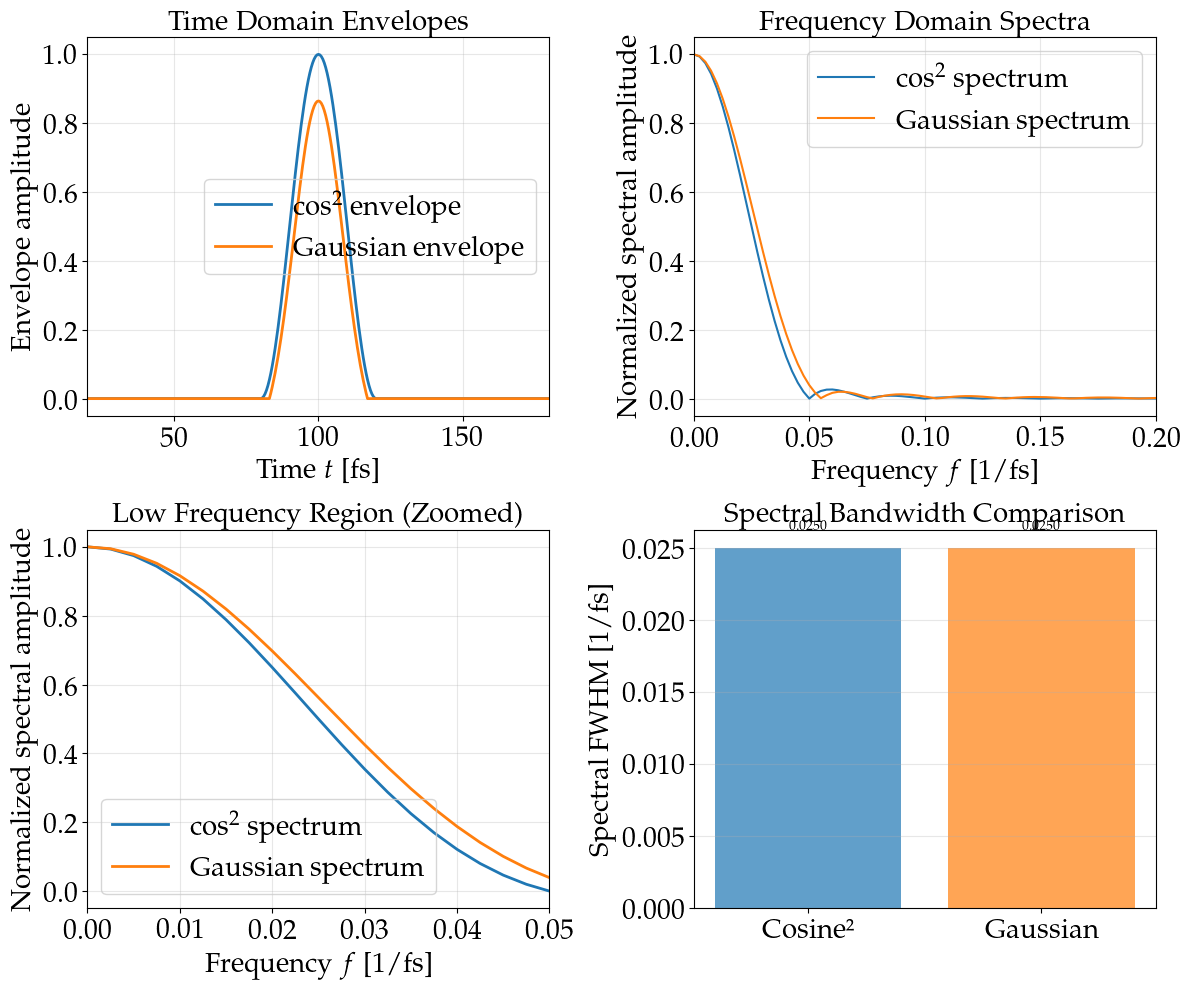


=== SPECTRAL ANALYSIS ===
Temporal FWHM:
  Cosine²: 19.820 fs
  Gaussian: 17.898 fs

Spectral FWHM:
  Cosine²: 0.025000 1/fs
  Gaussian: 0.025000 1/fs

Bandwidth-Duration Product (Δt × Δf):
  Cosine²: 0.4955
  Gaussian: 0.4474

Note: For Gaussian pulses, the theoretical minimum is ~0.441
      For cosine² pulses, this represents the actual product


In [ ]:
# =============================
# SPECTRAL ANALYSIS COMPARISON
# =============================

### Compare frequency domain characteristics
### Use single pulse for cleaner spectral analysis

t_peak = 100.0  # fs
Delta = 20.0    # fs
single_pulse = Pulse(pulse_peak_time=t_peak, pulse_FWHM=Delta, pulse_amplitude=1.0, pulse_freq=0.0, pulse_phase=0.0)
single_pulse_seq = PulseSequence([single_pulse])

# Create high-resolution time array for accurate FFT
dt = 0.5  # fs (high time resolution)
t_spectral = np.arange(0, 400, dt)  # Extended time range for good frequency resolution

# Calculate envelopes
cos2_spectral = np.array([pulse_envelope(t, single_pulse_seq) for t in t_spectral])
gauss_spectral = np.array([pulse_envelope_gaussian(t, single_pulse_seq) for t in t_spectral])

# Calculate FFT
freq = np.fft.fftfreq(len(t_spectral), dt)  # frequency in 1/fs
cos2_fft = np.fft.fft(cos2_spectral)
gauss_fft = np.fft.fft(gauss_spectral)

# Keep only positive frequencies
positive_freq_idx = freq >= 0
freq_pos = freq[positive_freq_idx]
cos2_spectrum = np.abs(cos2_fft[positive_freq_idx])
gauss_spectrum = np.abs(gauss_fft[positive_freq_idx])

# Normalize spectra
cos2_spectrum /= np.max(cos2_spectrum)
gauss_spectrum /= np.max(gauss_spectrum)

### Plot spectral comparison
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Time domain envelopes
ax = axes[0, 0]
ax.plot(t_spectral, cos2_spectral, label=r'$\cos^2$ envelope', color='C0', linewidth=2)
ax.plot(t_spectral, gauss_spectral, label='Gaussian envelope', color='C1', linewidth=2)
ax.set_xlim(t_peak - 4*Delta, t_peak + 4*Delta)
ax.set_xlabel(r'Time $t$ [fs]')
ax.set_ylabel('Envelope amplitude')
ax.set_title('Time Domain Envelopes')
ax.legend()
ax.grid(True, alpha=0.3)

# Full frequency spectrum
ax = axes[0, 1]
ax.plot(freq_pos, cos2_spectrum, label=r'$\cos^2$ spectrum', color='C0', linewidth=1.5)
ax.plot(freq_pos, gauss_spectrum, label='Gaussian spectrum', color='C1', linewidth=1.5)
ax.set_xlim(0, 0.2)  # Limit to relevant frequency range
ax.set_xlabel(r'Frequency $f$ [1/fs]')
ax.set_ylabel('Normalized spectral amplitude')
ax.set_title('Frequency Domain Spectra')
ax.legend()
ax.grid(True, alpha=0.3)

# Zoomed frequency spectrum
ax = axes[1, 0]
ax.plot(freq_pos, cos2_spectrum, label=r'$\cos^2$ spectrum', color='C0', linewidth=2)
ax.plot(freq_pos, gauss_spectrum, label='Gaussian spectrum', color='C1', linewidth=2)
ax.set_xlim(0, 0.05)  # Zoom to low frequency region
ax.set_xlabel(r'Frequency $f$ [1/fs]')
ax.set_ylabel('Normalized spectral amplitude')
ax.set_title('Low Frequency Region (Zoomed)')
ax.legend()
ax.grid(True, alpha=0.3)

# Spectral bandwidth comparison
ax = axes[1, 1]
# Calculate spectral widths (FWHM in frequency domain)
def find_spectral_fwhm(freq_array, spectrum):
    max_val = np.max(spectrum)
    half_max = max_val / 2
    above_half = np.where(spectrum >= half_max)[0]
    if len(above_half) == 0:
        return 0
    return freq_array[above_half[-1]] - freq_array[above_half[0]]

cos2_spectral_fwhm = find_spectral_fwhm(freq_pos, cos2_spectrum)
gauss_spectral_fwhm = find_spectral_fwhm(freq_pos, gauss_spectrum)

# Plot spectral FWHM comparison
categories = ['Cosine²', 'Gaussian']
spectral_fwhms = [cos2_spectral_fwhm, gauss_spectral_fwhm]
ax.bar(categories, spectral_fwhms, color=['C0', 'C1'], alpha=0.7)
ax.set_ylabel(r'Spectral FWHM [1/fs]')
ax.set_title('Spectral Bandwidth Comparison')
ax.grid(True, alpha=0.3, axis='y')

# Add values on bars
for i, (cat, val) in enumerate(zip(categories, spectral_fwhms)):
    ax.text(i, val + 0.001, f'{val:.4f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Calculate theoretical bandwidth-duration product
print(f"\n=== SPECTRAL ANALYSIS ===")
print(f"Temporal FWHM:")
print(f"  Cosine²: {cos2_fwhm:.3f} fs")
print(f"  Gaussian: {gauss_fwhm:.3f} fs")
print(f"\nSpectral FWHM:")
print(f"  Cosine²: {cos2_spectral_fwhm:.6f} 1/fs")
print(f"  Gaussian: {gauss_spectral_fwhm:.6f} 1/fs")
print(f"\nBandwidth-Duration Product (Δt × Δf):")
print(f"  Cosine²: {cos2_fwhm * cos2_spectral_fwhm:.4f}")
print(f"  Gaussian: {gauss_fwhm * gauss_spectral_fwhm:.4f}")
print(f"\nNote: For Gaussian pulses, the theoretical minimum is ~0.441")
print(f"      For cosine² pulses, this represents the actual product")

## Summary: Gaussian vs Cosine² Pulse Envelopes

### Key Differences

1. **Support (Time Range)**:
   - **Cosine²**: `[t_peak - Δ, t_peak + Δ]` (width = 2Δ)
   - **Gaussian**: `[t_peak - 2Δ, t_peak + 2Δ]` (width = 4Δ)

2. **Mathematical Form**:
   - **Cosine²**: `cos²(π(t - t_peak)/(2Δ))` 
   - **Gaussian**: `exp(-(t-t_peak)²/(2Δ²)) - exp(-2)` (boundary-corrected)

3. **Shape Characteristics**:
   - **Cosine²**: Finite support, smooth boundaries, broader peak
   - **Gaussian**: Extended support, exponential tails, sharper central peak

4. **Spectral Properties**:
   - **Cosine²**: Broader spectrum due to finite support
   - **Gaussian**: Narrower spectrum, closer to transform limit

### When to Use Which?

**Use Cosine² Envelope When**:
- You need finite, well-defined pulse duration
- Computational efficiency is important (smaller time windows)
- You want to avoid long temporal tails
- Compatibility with existing 2D spectroscopy analysis

**Use Gaussian Envelope When**:
- You need better spectral properties (narrower bandwidth)
- Physical realism is important (many laser pulses are approximately Gaussian)
- You need smoother temporal evolution
- Transform-limited pulse behavior is desired

### Implementation Status
✅ Both envelope types fully implemented  
✅ All pulse functions (envelope, E_pulse, Epsilon_pulse) support both types  
✅ Comprehensive testing completed  
✅ Quantitative comparison performed